__Capstone Project: NCAA Basketball Tournament Predictions__

__DSTC 691: Default Machine Learning Project__

__Name: Garrett Fanning__

# Introduction

The National Collegiate Basketball Association (NCAA) has over 350 colleges all competing to earn a spot in the NCAA tournament, with the ultimate goal of winning the tournament. Only 68 colleges are able to play well enough to earn a spot in the tournament. The lowest 8 teams play against each other to whittle down the field to 64 teams, from which a typical bracket style tournament can be created. 

For the most part, picking the winner of each game comes down to guessing or using your general basketball knowledge where it’s impossible to consistently predict games correctly. The NCAA tournament at first glance may appear to have a lot of randomness, which has led many people to leverage the vast amount of college basketball data out there to create algorithms that can have more predictability than the simple guessing or just picking the consensus favorite for each game.

I will use regular season data to help predict how that translates to success in the NCAA tournament. All of the features I will be using are averages or on a per game basis because all teams don’t play an equal amount of games in the regular season. Many of these features will not be used if they do not appear significant or are too similar to other features. I will predict winners of matchups in the NCAA tournament through predicting a final score differential, which can be interpreted as a positive differential means one team wins or negative would mean the other team. 

I was able to acquire the necessary data through 2 sources: the sportsreference website and through a csv uploaded by someone performing a similar project on the data.world website. The first source (sportsreference website) actually has a library in sklearn that is able to pull data directly through the site. From there I was able to pull 10 years of regular season data with 40 columns and 3478 rows of data. The second source(data.world) requires you to make an account on the site to actually download the csv. I was able to get tournament data dating back to 1985 with 2205 rows and 10 columns of data. Merging these datasets to eventually get to the relvant feature set was difficult where many of the team names that were supposed to match were actually different between the datasets. After cleaning and merging the data, I then did some exploratory analysis to narrow down the features to 29.

Those 29 features were scaled and then trained using different machine learning models with final score difference being the response variable. The regression models I used are Gradient Boosting, Random Forest, Decision Tree, K-Nearest Neigbors, Voting Ensemble of those 4 previous models, and ANN with tensorflow. Using MSE as a performance metric to determining the best performing model. The benchmark models I created to compare against were a model predicting by the better seed and the other predicting by the better record.

Flask was then used to deploy the best performing model. Using the Flask application, the feature data for a a tournament game matchup is fed to the application and a prediction on the final score difference will be provided using the best performing model.

# Data Description

## Source #1: https://www.sports-reference.com/cbb/

This dataset has 10 years of data with give or take 350 teams of season data per year.Some teams were added in the time period of the data resulting in an uneven amount of teams with data per year.
For each team looking at a single year, I collected 40 variables of data that were either statistical game averages or rankings/ratings they were given or earned in that same year.
The csv file that I downloaded from the API that directly pulls data from the sportsreference website was 789KB.
Definition of each column can be found here:https://www.sports-reference.com/cbb/about/glossary.html

## Source #2: https://data.world/michaelaroy/ncaa-tournament-results/workspace/file?filename=Big_Dance_CSV.csv

This dataset has tournament games dating back to 1985. For the range of data used in the models, only games from 2010-2019 are relevant. The only feature from this file are the seeds and the response variable of final score difference is from this dataset. The full dataset downloaded from the website has 2205 rows and 10 columns of data. The csv file size is 101KB.

# Libraries

## General Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sportsreference.ncaab.teams import Teams

from statsmodels.api import OLS


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pickle
import os
import flask
from flask import Flask, redirect, url_for,request, render_template
import math


## Table of Contents install

In [ ]:
#pip install --user jupyter_contrib_nbextensions
#jupyter contrib nbextension install --user
#jupyter nbextension enable toc2/main

## API to download data from sports reference website
Doesn't need to be run because data from here was stored in a csv, so that I wouldn't have to repeat this process each time I opened the notebook. The csv file will be provided in the Google Drive.

In [63]:
# #pip install pandas sklearn sportsreference  --> in terminal

# #Source: https://www.sports-reference.com/cbb/

# #!!!The code below will take minimum 5 minutes to run

# #to see what data/features are available
# #teams2019.dataframes.columns

# #creating an empty dataset to be filled 
# #all columns except for those with totals as all teams don't play the same amount of games

# dataset = pd.DataFrame(columns = ['year','name','abbreviation', 'assist_percentage', 'block_percentage', 
#                                       'effective_field_goal_percentage', 
#                                       'field_goal_percentage', 'free_throw_attempt_rate', 'free_throw_percentage',
#                                       'free_throws_per_field_goal_attempt', 
#                                       'offensive_rating', 'offensive_rebound_percentage',
#                                       'opp_assist_percentage',
#                                       'opp_block_percentage',
#                                       'opp_effective_field_goal_percentage','opp_field_goal_percentage',
#                                       'opp_free_throw_attempt_rate', 
#                                       'opp_free_throw_percentage',
#                                       'opp_free_throws_per_field_goal_attempt', 'opp_offensive_rating',
#                                       'opp_offensive_rebound_percentage',
#                                       'opp_steal_percentage',
#                                       'opp_three_point_attempt_rate','opp_three_point_field_goal_percentage',
#                                       'opp_two_point_field_goal_percentage','opp_total_rebound_percentage',
#                                       'opp_true_shooting_percentage', 'opp_turnover_percentage',
#                                       'pace', 'simple_rating_system', 'steal_percentage',
#                                       'strength_of_schedule', 'three_point_attempt_rate',
#                                       'three_point_field_goal_percentage',
#                                       'two_point_field_goal_percentage', 'two_point_field_goals',
#                                       'total_rebound_percentage',
#                                       'true_shooting_percentage', 'turnover_percentage','win_percentage'])
# for yearVal in range(2010,2020,1):

#     team = Teams(year = str(yearVal))
    
#     temp = {'year':[str(yearVal)]*sum(team.dataframes['name'].value_counts()), 'name':team.dataframes.name,'abbreviation':team.dataframes.abbreviation, 
#                               'assist_percentage':team.dataframes.assist_percentage,'block_percentage':team.dataframes.block_percentage,
#                               'effective_field_goal_percentage' : team.dataframes.effective_field_goal_percentage,
#                               'field_goal_percentage':team.dataframes.field_goal_percentage, 'free_throw_attempt_rate':team.dataframes.free_throw_attempt_rate, 
#                               'free_throw_percentage':team.dataframes.free_throw_percentage,
#                               'free_throws_per_field_goal_attempt':team.dataframes.free_throws_per_field_goal_attempt, 'offensive_rating': team.dataframes.offensive_rating, 
#                               'offensive_rebound_percentage':team.dataframes.offensive_rebound_percentage,'opp_assist_percentage':team.dataframes.opp_assist_percentage,
#                               'opp_block_percentage': team.dataframes.opp_block_percentage,'opp_effective_field_goal_percentage':team.dataframes.opp_effective_field_goal_percentage,
#                               'opp_field_goal_percentage':team.dataframes.opp_field_goal_percentage, 'opp_free_throw_attempt_rate':team.dataframes.opp_free_throw_attempt_rate, 
#                               'opp_free_throw_percentage': team.dataframes.opp_free_throw_percentage,
#                               'opp_free_throws_per_field_goal_attempt': team.dataframes.opp_free_throws_per_field_goal_attempt, 'opp_offensive_rating':team.dataframes.opp_offensive_rating,
#                               'opp_offensive_rebound_percentage': team.dataframes.opp_offensive_rebound_percentage,
#                               'opp_steal_percentage': team.dataframes.opp_steal_percentage,
#                               'opp_three_point_attempt_rate': team.dataframes.opp_three_point_attempt_rate,
#                               'opp_three_point_field_goal_percentage' : team.dataframes.opp_three_point_field_goal_percentage,
#                               'opp_two_point_field_goal_percentage': team.dataframes.opp_two_point_field_goal_percentage,
#                               'opp_total_rebound_percentage' : team.dataframes.opp_total_rebound_percentage,
#                               'opp_true_shooting_percentage':  team.dataframes.opp_true_shooting_percentage, 'opp_turnover_percentage':team.dataframes.opp_turnover_percentage,
#                               'pace': team.dataframes.pace, 'simple_rating_system': team.dataframes.simple_rating_system, 'steal_percentage': team.dataframes.steal_percentage,
#                               'strength_of_schedule': team.dataframes.strength_of_schedule, 'three_point_attempt_rate':team.dataframes.three_point_attempt_rate,
#                               'three_point_field_goal_percentage': team.dataframes.three_point_field_goal_percentage,
#                               'two_point_field_goal_percentage': team.dataframes.two_point_field_goal_percentage, 'two_point_field_goals':team.dataframes.two_point_field_goals,
#                               'total_rebound_percentage': team.dataframes.total_rebound_percentage,'true_shooting_percentage':team.dataframes.true_shooting_percentage, 
#                               'turnover_percentage': team.dataframes.turnover_percentage, 'win_percentage':team.dataframes.win_percentage}
#     df_temp = pd.DataFrame(data=temp)
    
#     dataset = dataset.append(df_temp,ignore_index=True)

# dataset.to_csv('season_results.csv')   
# dataset

,year,name,abbreviation,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,free_throws_per_field_goal_attempt,...,steal_percentage,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,two_point_field_goals,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage
0,2010,Air Force,AIR-FORCE,61.6,6.2,0.504,0.443,0.367,0.635,0.233,...,8.4,3.13,0.394,0.313,0.527,456,46.8,0.529,19.0,0.323
1,2010,Akron,AKRON,53.9,8.5,0.491,0.433,0.363,0.657,0.239,...,9.0,-1.50,0.343,0.339,0.483,642,51.6,0.521,16.4,0.686
2,2010,Alabama A&M,ALABAMA-AM,48.1,12.7,0.416,0.382,0.474,0.635,0.301,...,12.5,-13.71,0.237,0.291,0.410,491,46.8,0.463,18.8,0.407
3,2010,UAB,ALABAMA-BIRMINGHAM,51.1,7.3,0.471,0.422,0.457,0.694,0.317,...,10.0,2.90,0.315,0.311,0.474,586,53.6,0.518,17.0,0.735
4,2010,Alabama State,ALABAMA-STATE,60.0,11.1,0.462,0.404,0.448,0.641,0.287,...,10.8,-12.02,0.356,0.324,0.448,477,51.3,0.499,20.0,0.516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473,2019,Wright State,WRIGHT-STATE,54.7,6.1,0.506,0.436,0.341,0.737,0.251,...,9.0,-0.89,0.403,0.344,0.499,604,52.3,0.543,14.6,0.600
3474,2019,Wyoming,WYOMING,48.0,7.9,0.492,0.417,0.399,0.723,0.288,...,7.8,0.19,0.435,0.344,0.472,442,44.7,0.534,18.6,0.250
3475,2019,Xavier,XAVIER,56.3,10.6,0.528,0.466,0.326,0.679,0.221,...,8.1,8.06,0.374,0.331,0.547,677,53.4,0.553,16.5,0.543
3476,2019,Yale,YALE,56.3,11.2,0.556,0.493,0.307,0.738,0.227,...,8.0,-1.24,0.350,0.363,0.563,663,52.9,0.584,15.9,0.733


# Import Data

## Import season results from csv file created through API

This dataset has 10 years of data with give or take 350 teams of season data per year.Some teams were added in the time period of the data resulting in an uneven amount of teams with data per year.
For each team looking at a single year, I collected 40 variables of data that were either statistical game averages or rankings/ratings they were given or earned in that same year.
The csv file that I downloaded from the API that directly pulls data from the sportsreference website was 101KB.

In [2]:
#Import data from file named below

fileName = "season_results.csv"

season_results = pd.read_csv(fileName)

#Drop index column, year should be the first column with real data
season_results = season_results.iloc[: , 1:]

season_results

,year,name,abbreviation,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,free_throws_per_field_goal_attempt,...,steal_percentage,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,two_point_field_goals,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage
0,2010,Air Force,AIR-FORCE,61.6,6.2,0.504,0.443,0.367,0.635,0.233,...,8.4,3.13,0.394,0.313,0.527,456,46.8,0.529,19.0,0.323
1,2010,Akron,AKRON,53.9,8.5,0.491,0.433,0.363,0.657,0.239,...,9.0,-1.50,0.343,0.339,0.483,642,51.6,0.521,16.4,0.686
2,2010,Alabama A&M,ALABAMA-AM,48.1,12.7,0.416,0.382,0.474,0.635,0.301,...,12.5,-13.71,0.237,0.291,0.410,491,46.8,0.463,18.8,0.407
3,2010,UAB,ALABAMA-BIRMINGHAM,51.1,7.3,0.471,0.422,0.457,0.694,0.317,...,10.0,2.90,0.315,0.311,0.474,586,53.6,0.518,17.0,0.735
4,2010,Alabama State,ALABAMA-STATE,60.0,11.1,0.462,0.404,0.448,0.641,0.287,...,10.8,-12.02,0.356,0.324,0.448,477,51.3,0.499,20.0,0.516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3473,2019,Wright State,WRIGHT-STATE,54.7,6.1,0.506,0.436,0.341,0.737,0.251,...,9.0,-0.89,0.403,0.344,0.499,604,52.3,0.543,14.6,0.600
3474,2019,Wyoming,WYOMING,48.0,7.9,0.492,0.417,0.399,0.723,0.288,...,7.8,0.19,0.435,0.344,0.472,442,44.7,0.534,18.6,0.250
3475,2019,Xavier,XAVIER,56.3,10.6,0.528,0.466,0.326,0.679,0.221,...,8.1,8.06,0.374,0.331,0.547,677,53.4,0.553,16.5,0.543
3476,2019,Yale,YALE,56.3,11.2,0.556,0.493,0.307,0.738,0.227,...,8.0,-1.24,0.350,0.363,0.563,663,52.9,0.584,15.9,0.733


In [3]:
#Get statistics on each column
season_results.describe()

,year,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,free_throws_per_field_goal_attempt,offensive_rating,offensive_rebound_percentage,...,steal_percentage,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,two_point_field_goals,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage
count,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,...,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000
mean,2014.537378,52.964232,9.377343,0.498732,0.438739,0.364334,0.697412,0.254014,103.085394,30.845055,...,9.319781,-0.268013,0.346862,0.344737,0.488852,585.951696,49.776049,0.533385,16.513197,0.510287
std,2.864129,5.291287,2.653611,0.031027,0.025613,0.051574,0.037643,0.037891,6.374616,4.153471,...,1.668816,5.417745,0.056507,0.028127,0.033142,85.679835,2.823297,0.029409,1.866464,0.173178
min,2010.000000,34.700000,2.900000,0.397000,0.347000,0.210000,0.541000,0.141000,75.700000,15.600000,...,4.200000,-13.710000,0.108000,0.248000,0.382000,349.000000,37.700000,0.433000,10.500000,0.000000
25%,2012.000000,49.300000,7.400000,0.478000,0.422000,0.329000,0.672000,0.228000,99.000000,28.100000,...,8.200000,-4.310000,0.307000,0.326000,0.466000,525.000000,47.900000,0.514000,15.225000,0.387000
50%,2015.000000,52.900000,9.200000,0.499000,0.439000,0.363000,0.698000,0.253000,103.200000,31.000000,...,9.200000,-1.460000,0.345500,0.345000,0.488000,581.000000,49.900000,0.533000,16.400000,0.515000
75%,2017.000000,56.475000,11.100000,0.520000,0.456000,0.398000,0.723000,0.279000,107.300000,33.800000,...,10.400000,4.010000,0.384000,0.363000,0.511000,640.000000,51.700000,0.552000,17.700000,0.636000
max,2019.000000,74.000000,20.400000,0.605000,0.526000,0.593000,0.818000,0.415000,122.300000,45.400000,...,17.000000,12.790000,0.582000,0.447000,0.627000,1011.000000,58.600000,0.639000,23.700000,0.974000


In [4]:
#Some percentages were listed as 50.0 instead of .500
#To be consistent with all features, any feature with percentage in the name will be less than 1
season_results['assist_percentage'] = season_results['assist_percentage']/100
season_results['block_percentage'] = season_results['block_percentage']/100
season_results['offensive_rebound_percentage'] = season_results['offensive_rebound_percentage']/100
season_results['opp_assist_percentage'] = season_results['opp_assist_percentage']/100
season_results['opp_block_percentage'] = season_results['opp_block_percentage']/100
season_results['opp_offensive_rebound_percentage'] = season_results['opp_offensive_rebound_percentage']/100
season_results['opp_steal_percentage'] = season_results['opp_steal_percentage']/100
season_results['opp_total_rebound_percentage'] = season_results['opp_total_rebound_percentage']/100
season_results['opp_turnover_percentage'] = season_results['opp_turnover_percentage']/100
season_results['steal_percentage'] = season_results['steal_percentage']/100
season_results['opp_turnover_percentage'] = season_results['opp_turnover_percentage']/100
season_results['total_rebound_percentage'] = season_results['total_rebound_percentage']/100
season_results['turnover_percentage'] = season_results['turnover_percentage']/100

In [5]:
season_results.describe()

,year,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,free_throws_per_field_goal_attempt,offensive_rating,offensive_rebound_percentage,...,steal_percentage,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,two_point_field_goals,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage
count,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,...,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000,3478.000000
mean,2014.537378,0.529642,0.093773,0.498732,0.438739,0.364334,0.697412,0.254014,103.085394,0.308451,...,0.093198,-0.268013,0.346862,0.344737,0.488852,585.951696,0.497760,0.533385,0.165132,0.510287
std,2.864129,0.052913,0.026536,0.031027,0.025613,0.051574,0.037643,0.037891,6.374616,0.041535,...,0.016688,5.417745,0.056507,0.028127,0.033142,85.679835,0.028233,0.029409,0.018665,0.173178
min,2010.000000,0.347000,0.029000,0.397000,0.347000,0.210000,0.541000,0.141000,75.700000,0.156000,...,0.042000,-13.710000,0.108000,0.248000,0.382000,349.000000,0.377000,0.433000,0.105000,0.000000
25%,2012.000000,0.493000,0.074000,0.478000,0.422000,0.329000,0.672000,0.228000,99.000000,0.281000,...,0.082000,-4.310000,0.307000,0.326000,0.466000,525.000000,0.479000,0.514000,0.152250,0.387000
50%,2015.000000,0.529000,0.092000,0.499000,0.439000,0.363000,0.698000,0.253000,103.200000,0.310000,...,0.092000,-1.460000,0.345500,0.345000,0.488000,581.000000,0.499000,0.533000,0.164000,0.515000
75%,2017.000000,0.564750,0.111000,0.520000,0.456000,0.398000,0.723000,0.279000,107.300000,0.338000,...,0.104000,4.010000,0.384000,0.363000,0.511000,640.000000,0.517000,0.552000,0.177000,0.636000
max,2019.000000,0.740000,0.204000,0.605000,0.526000,0.593000,0.818000,0.415000,122.300000,0.454000,...,0.170000,12.790000,0.582000,0.447000,0.627000,1011.000000,0.586000,0.639000,0.237000,0.974000


In [6]:
#See if there are any missing cells of data
season_results.isnull().sum()

year                                         0
name                                         0
abbreviation                                 0
assist_percentage                            0
block_percentage                             0
effective_field_goal_percentage              0
field_goal_percentage                        0
free_throw_attempt_rate                      0
free_throw_percentage                        0
free_throws_per_field_goal_attempt           0
offensive_rating                             0
offensive_rebound_percentage                 0
opp_assist_percentage                        0
opp_block_percentage                         0
opp_effective_field_goal_percentage          0
opp_field_goal_percentage                    0
opp_free_throw_attempt_rate                  0
opp_free_throw_percentage                    0
opp_free_throws_per_field_goal_attempt       0
opp_offensive_rating                      3478
opp_offensive_rebound_percentage             0
opp_steal_per

In [7]:
# Completely empty column and so it is impossible to impute values to fill it up
season_results=season_results.drop(columns=['opp_offensive_rating'])

## Import Tournament Results Data from csv file found online

In [8]:
#Import data from file named below
#Source: https://data.world/michaelaroy/ncaa-tournament-results/workspace/file?filename=Big_Dance_CSV.csv

fileName = "Big_Dance_CSV.csv"

tourney_results = pd.read_csv(fileName)
tourney_results

,Year,Round,Region Number,Region Name,Seed,Score,Team,Team.1,Score.1,Seed.1
0,1985,1,1,West,1,83,St Johns,Southern,59,16
1,1985,1,1,West,2,81,VCU,Marshall,65,15
2,1985,1,1,West,3,65,NC State,Nevada,56,14
3,1985,1,1,West,4,85,UNLV,San Diego St,80,13
4,1985,1,1,West,5,58,Washington,Kentucky,65,12
...,...,...,...,...,...,...,...,...,...,...
2200,2019,4,3,East,1,80,Virginia,Purdue,75,3
2201,2019,4,4,Midwest,5,77,Auburn,Kentucky,71,2
2202,2019,5,1,Final Four,2,51,Michigan St,Texas Tech,61,3
2203,2019,5,2,Final Four,1,63,Virginia,Auburn,62,5


In [9]:
tourney_results.describe()

,Year,Round,Region Number,Seed,Score,Score.1,Seed.1
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,2002.000000,1.904762,2.444444,3.887528,74.304308,68.051701,9.474830
std,10.101796,1.191698,1.123993,2.900662,12.753399,12.295443,4.138256
min,1985.000000,1.000000,1.000000,1.000000,32.000000,29.000000,1.000000
25%,1993.000000,1.000000,1.000000,2.000000,65.000000,59.000000,6.000000
50%,2002.000000,1.000000,2.000000,3.000000,74.000000,67.000000,10.000000
75%,2011.000000,2.000000,3.000000,6.000000,82.000000,76.000000,13.000000
max,2019.000000,6.000000,4.000000,16.000000,131.000000,149.000000,16.000000


<AxesSubplot:>

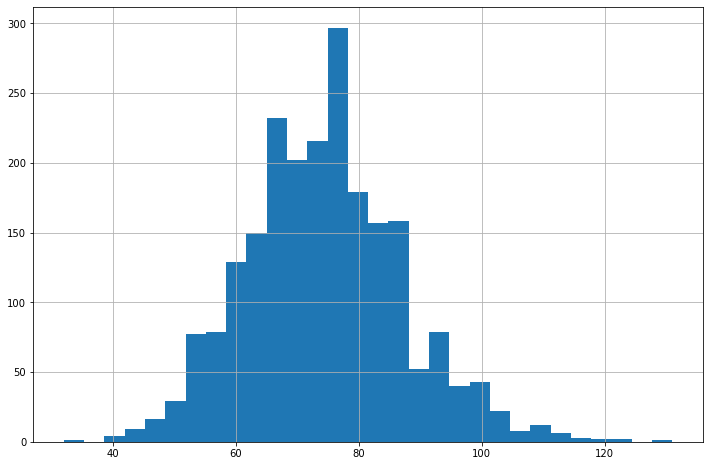

In [10]:
#See distribution of score column that will be used in the calculation of the response variable
tourney_results['Score'].hist(bins=30, figsize=(12, 8))

In [11]:
#Looking into unusually high score found
tourney_results.iloc[tourney_results['Score'].idxmax()]

Year                         1990
Round                           4
Region Number                   2
Region Name                  West
Seed                            1
Score                         131
Team                         UNLV
Team.1           Loyola Marymount
Score.1                       101
Seed.1                         11
Name: 372, dtype: object

Confirmed on the sportsreference website at : https://www.sports-reference.com/cbb/boxscores/1990-03-25-loyola-marymount.html
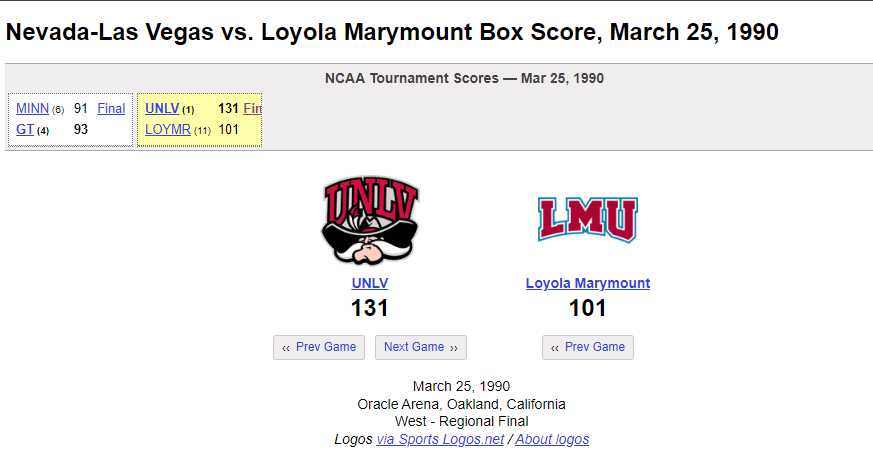

In [12]:
#Confirm there is no missing values
tourney_results.isnull().sum()

Year             0
Round            0
Region Number    0
Region Name      0
Seed             0
Score            0
Team             0
Team.1           0
Score.1          0
Seed.1           0
dtype: int64

In [13]:
#Select columns needed from dataframe created using the csv file
tourney_results = pd.DataFrame(tourney_results,columns =['Year','Seed','Score','Team','Team.1','Score.1','Seed.1'])

#Only need tournament games from 2010-2019
tourney_results_features = tourney_results[(tourney_results['Year'] > 2009) & (tourney_results['Year'] < 2020)]
tourney_results_features


,Year,Seed,Score,Team,Team.1,Score.1,Seed.1
1575,2010,1,90,Kansas,Lehigh,74,16
1576,2010,2,68,Ohio St,Santa Barbara,51,15
1577,2010,3,83,Georgetown,Ohio,97,14
1578,2010,4,89,Maryland,Houston,77,13
1579,2010,5,70,Michigan St,New Mexico St,67,12
...,...,...,...,...,...,...,...
2200,2019,1,80,Virginia,Purdue,75,3
2201,2019,5,77,Auburn,Kentucky,71,2
2202,2019,2,51,Michigan St,Texas Tech,61,3
2203,2019,1,63,Virginia,Auburn,62,5


# Merge Season Results & Tourney Results DataFrames

The goal here is to first get the 2 data sources(Tournament Results & Season Results) into the right state to be merged together. The process will be to merge the season results of the home team in the tournament games into 1 DataFrame. The other DataFrame would be the merge of the away team. Then simply taking the Home Team Dataframe and subracting from it the Away Team DataFrame would give the required Season Statistic Differentials that could be used as the features with the final game score differential in each tournament game being the response. Using the data like this would accomplish my initial goal of trying to find/establish a relationship between how teams performed in the regular season would lead to success in the tournament. 

## Rename team names in tournament results DataFrame to match with correct team names in season result DataFrame

In [14]:
# Using exported csvs from both data sources, exported csvs stored in Google Drive
# Compared both datasets to compare and change team names to match
# Manually change ' to \' for 5 team names

tourney_results_features = tourney_results_features.replace({'Alabama St':'Alabama State','Albany':'Albany (NY)','Alcorn St':'Alcorn State','Arizona St':'Arizona State',
                                 'Arkansas Little Rock':'Little Rock','Arkansas Pine Bluff':'Arkansas-Pine Bluff','Ball St':'Ball State','Boise St':'Boise State',
                                 'BYU':'Brigham Young','Cal Irvine':'UC Irvine','Cal St Bakersfield':'Cal State Bakersfield', 'Cal St Fullerton':'Cal State Fullerton','Cal St Northridge':'Cal State Northridge',
                                 'Central Connecticut St':'Central Connecticut State','Cleveland St':'Cleveland State',
                                    'Colorado St':'Colorado State',
                                    'Coppin St':'Coppin State',
                                    'Delaware St':'Delaware State',
                                    'Detroit':'Detroit Mercy',
                                    'East Tennessee St':'East Tennessee State',
                                    'Florida St':'Florida State',
                                    'Fresno St':'Fresno State',
                                    'Gardner Webb':'Gardner-Webb',
                                    'Georgia St':'Georgia State',
                                    'Idaho St':'Idaho State',
                                    'Illinois Chicago':'Illinois-Chicago',
                                    'Illinois St':'Illinois State',
                                    'Indiana St':'Indiana State',
                                    'Iowa St':'Iowa State',
                                    'Jackson St':'Jackson State',
                                    'Jacksonville St':'Jacksonville State',
                                    'Kansas St':'Kansas State',
                                    'Kent St':'Kent State',
                                    'Long Beach St':'Long Beach State',
                                    'Long Island Brooklyn':'Long Island University',
                                    'Louisiana Lafayette':'Lafayette',
                                    'Louisiana Monroe':'Louisiana-Monroe',
                                    'Loyola Chicago':'Loyola (IL)',
                                    'Loyola Illinois':'Loyola (IL)',
                                    'Loyola Maryland':'Loyola (MD)',
                                    'LSU':'Louisiana State',
                                    'McNeese St':'McNeese State',
                                    'Miami':'Miami (FL)',
                                    'Miami Ohio':'Miami (OH)',
                                    'Michigan St':'Michigan State',
                                    'Middle Tennessee St':'Middle Tennessee',
                                    'Mississippi St':'Mississippi State',
                                    'Mississippi Valley St':'Mississippi Valley State',
                                    'Montana St':'Montana State',
                                    'Morehead St':'Morehead State',
                                    'Morgan St':'Morgan State',                         
                                    'Mount St Marys':'Mount St. Mary\'s',
                                    'Murray St':'Murray State',
                                    'New Mexico St':'New Mexico State',
                                    'Nicholls St':'Nicholls State',
                                    'Norfolk St':'Norfolk State',                         
                                    'North Dakota St':'North Dakota State',
                                    'North Texas St':'North Texas',
                                    'Northwestern St':'Northwestern State',
                                    'Ohio St':'Ohio State',
                                    'Oklahoma St':'Oklahoma State',
                                    'Ole Miss':'Mississippi',
                                    'Oregon St':'Oregon State',
                                    'Penn St':'Penn State',
                                    'Portland St':'Portland State',
                                    'Sam Houston St':'Sam Houston State',
                                    'San Diego St':'San Diego State',
                                    'San Jose St':'San Jose State',
                                    'Santa Barbara':'UC Santa Barbara',
                                    'SMU':'Southern Methodist',
                                    'South Carolina St':'South Carolina State',
                                    'South Dakota St':'South Dakota State',                         
                                    'Southeast Missouri St':'Southeast Missouri State',
                                    'Southwest Missouri St':'Missouri State',
                                    'Southwest Texas St':'Texas State',
                                    'St Bonaventure':'St. Bonaventure',
                                    'St Francis':'Saint Francis (PA)',
                                    'St Johns':'St. John\'s (NY)',
                                    'St Josephs':'Saint Joseph\'s',
                                    'St Louis':'Saint Louis',
                                    'St Marys':'Saint Mary\'s (CA)',
                                    'St Peters':'Saint Peter\'s',
                                    'Stephen F Austin':'Stephen F. Austin',
                                    'Tennessee St':'Tennessee State',
                                    'Texas A&M Corpus Christi':'Texas A&M-Corpus Christi',
                                    'Texas Arlington':'UT Arlington',
                                    'Texas San Antonio':'UTSA',
                                    'UMBC':'Maryland-Baltimore County',
                                    'UNLV':'Nevada-Las Vegas',
                                    'USC':'Southern California',
                                    'Utah St':'Utah State',
                                    'VCU':'Virginia Commonwealth',
                                    'Washington St':'Washington State',
                                    'Weber St':'Weber State',
                                    'Wichita St':'Wichita State',
                                    'Wisconsin Green Bay':'Green Bay',
                                    'Wisconsin Milwaukee':'Milwaukee',
                                    'Wright St':'Wright State'})

In [ ]:
# #DO NOT RUN
# #This was used to find initial differences in datasets for team names
# #Exported team name lists to csv and then manually scanned to see what changes needed to be made

# merged_dataset_away['Away_Team'].value_counts()

# counts_SeasonResults = dataset.value_counts(['name']) #counts_SeasonResults.to_csv('counts_SeasonResults.csv')

# counts_TourneyResults = tourney_results_features.value_counts(['Home_Team','Away_Team']) counts_TourneyResults.to_csv('counts_TourneyResults_v2.csv')

# counts_merged_away = merged_dataset_away.value_counts(['Away_Team']) counts_merged_away.to_csv('counts_merged_away.csv')

# counts_merged_home = merged_dataset_home.value_counts(['Home_Team']) counts_merged_home.to_csv('counts_merged_home.csv')

## Prepare DataFrames to be merged

In [15]:
#Rename features
tourney_results_features = tourney_results_features.rename(columns={"Seed":"Home_Seed","Score":"Home_Score","Team":"Home_Team","Team.1":"Away_Team",
                                        "Score.1":"Away_Score","Seed.1":"Away_Seed"})


In [16]:
season_results['name'].value_counts()

Campbell                10
South Florida           10
Coastal Carolina        10
North Texas             10
Montana State           10
                        ..
Incarnate Word           6
Massachusetts-Lowell     6
Centenary (LA)           2
California Baptist       1
North Alabama            1
Name: name, Length: 354, dtype: int64

In [17]:
tourney_results_features['Home_Team'].value_counts()

Kentucky               31
Kansas                 30
Duke                   27
North Carolina         25
Michigan State         21
                       ..
Illinois                1
Loyola (IL)             1
Lehigh                  1
Wofford                 1
Southern California     1
Name: Home_Team, Length: 109, dtype: int64

In [18]:
#Looking into dtypes for both datasets to make sure matching columns also have matching dtypes
tourney_results.dtypes

Year        int64
Seed        int64
Score       int64
Team       object
Team.1     object
Score.1     int64
Seed.1      int64
dtype: object

In [19]:
season_results.dtypes

year                                        int64
name                                       object
abbreviation                               object
assist_percentage                         float64
block_percentage                          float64
effective_field_goal_percentage           float64
field_goal_percentage                     float64
free_throw_attempt_rate                   float64
free_throw_percentage                     float64
free_throws_per_field_goal_attempt        float64
offensive_rating                          float64
offensive_rebound_percentage              float64
opp_assist_percentage                     float64
opp_block_percentage                      float64
opp_effective_field_goal_percentage       float64
opp_field_goal_percentage                 float64
opp_free_throw_attempt_rate               float64
opp_free_throw_percentage                 float64
opp_free_throws_per_field_goal_attempt    float64
opp_offensive_rebound_percentage          float64


In [20]:
#Initially had issues with merging because season_results was a different data type between the 2 sources
season_results['year'] = pd.to_numeric(season_results['year'])
season_results.dtypes

year                                        int64
name                                       object
abbreviation                               object
assist_percentage                         float64
block_percentage                          float64
effective_field_goal_percentage           float64
field_goal_percentage                     float64
free_throw_attempt_rate                   float64
free_throw_percentage                     float64
free_throws_per_field_goal_attempt        float64
offensive_rating                          float64
offensive_rebound_percentage              float64
opp_assist_percentage                     float64
opp_block_percentage                      float64
opp_effective_field_goal_percentage       float64
opp_field_goal_percentage                 float64
opp_free_throw_attempt_rate               float64
opp_free_throw_percentage                 float64
opp_free_throws_per_field_goal_attempt    float64
opp_offensive_rebound_percentage          float64


## Merge home team tournament games to the season results in that year

In [21]:
#Merge home team tournament games to the season results in that year
merged_dataset_home = pd.merge(season_results,tourney_results_features,how='inner',left_on=['year','name'],right_on=['Year','Home_Team'],validate="1:m")
merged_dataset_home

,year,name,abbreviation,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,free_throws_per_field_goal_attempt,...,true_shooting_percentage,turnover_percentage,win_percentage,Year,Home_Seed,Home_Score,Home_Team,Away_Team,Away_Score,Away_Seed
0,2010,Baylor,BAYLOR,0.512,0.174,0.549,0.487,0.358,0.725,0.260,...,0.580,0.171,0.778,2010,3,68,Baylor,Sam Houston State,59,14
1,2010,Baylor,BAYLOR,0.512,0.174,0.549,0.487,0.358,0.725,0.260,...,0.580,0.171,0.778,2010,3,76,Baylor,Old Dominion,68,11
2,2010,Brigham Young,BRIGHAM-YOUNG,0.553,0.091,0.552,0.483,0.388,0.790,0.307,...,0.596,0.142,0.833,2010,7,99,Brigham Young,Florida,92,10
3,2010,Butler,BUTLER,0.549,0.065,0.510,0.442,0.469,0.738,0.346,...,0.559,0.163,0.868,2010,5,77,Butler,UTEP,59,12
4,2010,Butler,BUTLER,0.549,0.065,0.510,0.442,0.469,0.738,0.346,...,0.559,0.163,0.868,2010,5,63,Butler,Kansas State,56,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2019,Virginia,VIRGINIA,0.559,0.130,0.552,0.474,0.291,0.744,0.216,...,0.580,0.128,0.921,2019,1,53,Virginia,Oregon,49,12
626,2019,Virginia,VIRGINIA,0.559,0.130,0.552,0.474,0.291,0.744,0.216,...,0.580,0.128,0.921,2019,1,80,Virginia,Purdue,75,3
627,2019,Virginia,VIRGINIA,0.559,0.130,0.552,0.474,0.291,0.744,0.216,...,0.580,0.128,0.921,2019,1,63,Virginia,Auburn,62,5
628,2019,Wisconsin,WISCONSIN,0.492,0.110,0.511,0.449,0.273,0.648,0.177,...,0.531,0.130,0.676,2019,5,54,Wisconsin,Oregon,72,12


In [22]:
#Confirm merge dataset rows equal to amount of games in 2010-2019 tourney results dataframe
len(tourney_results_features)

630

In [23]:
merged_dataset_home.isnull().sum()

year                                      0
name                                      0
abbreviation                              0
assist_percentage                         0
block_percentage                          0
effective_field_goal_percentage           0
field_goal_percentage                     0
free_throw_attempt_rate                   0
free_throw_percentage                     0
free_throws_per_field_goal_attempt        0
offensive_rating                          0
offensive_rebound_percentage              0
opp_assist_percentage                     0
opp_block_percentage                      0
opp_effective_field_goal_percentage       0
opp_field_goal_percentage                 0
opp_free_throw_attempt_rate               0
opp_free_throw_percentage                 0
opp_free_throws_per_field_goal_attempt    0
opp_offensive_rebound_percentage          0
opp_steal_percentage                      0
opp_three_point_attempt_rate              0
opp_three_point_field_goal_perce

## Merge away team tournament games to the season results in that year

In [24]:
merged_dataset_away = pd.merge(season_results,tourney_results_features,how='inner',left_on=['year','name'],right_on=['Year','Away_Team'],validate="1:m")
merged_dataset_away

,year,name,abbreviation,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,free_throws_per_field_goal_attempt,...,true_shooting_percentage,turnover_percentage,win_percentage,Year,Home_Seed,Home_Score,Home_Team,Away_Team,Away_Score,Away_Seed
0,2010,Arkansas-Pine Bluff,ARKANSAS-PINE-BLUFF,0.581,0.102,0.447,0.408,0.484,0.668,0.323,...,0.495,0.206,0.529,2010,1,73,Duke,Arkansas-Pine Bluff,44,16
1,2010,Baylor,BAYLOR,0.512,0.174,0.549,0.487,0.358,0.725,0.260,...,0.580,0.171,0.778,2010,10,49,Saint Mary's (CA),Baylor,72,3
2,2010,Baylor,BAYLOR,0.512,0.174,0.549,0.487,0.358,0.725,0.260,...,0.580,0.171,0.778,2010,1,78,Duke,Baylor,71,3
3,2010,Brigham Young,BRIGHAM-YOUNG,0.553,0.091,0.552,0.483,0.388,0.790,0.307,...,0.596,0.142,0.833,2010,2,84,Kansas State,Brigham Young,72,7
4,2010,Butler,BUTLER,0.549,0.065,0.510,0.442,0.469,0.738,0.346,...,0.559,0.163,0.868,2010,13,52,Murray State,Butler,54,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2019,Virginia,VIRGINIA,0.559,0.130,0.552,0.474,0.291,0.744,0.216,...,0.580,0.128,0.921,2019,3,77,Texas Tech,Virginia,85,1
626,2019,Washington,WASHINGTON,0.475,0.163,0.521,0.451,0.347,0.695,0.241,...,0.551,0.174,0.750,2019,8,61,Utah State,Washington,78,9
627,2019,Washington,WASHINGTON,0.475,0.163,0.521,0.451,0.347,0.695,0.241,...,0.551,0.174,0.750,2019,1,81,North Carolina,Washington,59,9
628,2019,Wofford,WOFFORD,0.506,0.091,0.580,0.490,0.271,0.704,0.190,...,0.598,0.135,0.857,2019,2,62,Kentucky,Wofford,56,7


## Sort merge away and merge home to make sure same games are in correct order for both DataFrames before finding differences

In [25]:
merged_dataset_away = merged_dataset_away.sort_values(by=['year', 'Home_Team','Away_Team'])
merged_dataset_away = merged_dataset_away.reset_index(drop=True)
merged_dataset_away

,year,name,abbreviation,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,free_throws_per_field_goal_attempt,...,true_shooting_percentage,turnover_percentage,win_percentage,Year,Home_Seed,Home_Score,Home_Team,Away_Team,Away_Score,Away_Seed
0,2010,Old Dominion,OLD-DOMINION,0.601,0.086,0.488,0.447,0.303,0.648,0.197,...,0.512,0.162,0.750,2010,3,76,Baylor,Old Dominion,68,11
1,2010,Sam Houston State,SAM-HOUSTON-STATE,0.740,0.070,0.536,0.463,0.370,0.703,0.260,...,0.567,0.161,0.758,2010,3,68,Baylor,Sam Houston State,59,14
2,2010,Florida,FLORIDA,0.538,0.072,0.494,0.444,0.334,0.703,0.235,...,0.528,0.154,0.618,2010,7,99,Brigham Young,Florida,92,10
3,2010,Duke,DUKE,0.529,0.098,0.505,0.442,0.379,0.759,0.287,...,0.549,0.133,0.875,2010,5,59,Butler,Duke,61,1
4,2010,Kansas State,KANSAS-STATE,0.551,0.132,0.508,0.450,0.503,0.668,0.336,...,0.545,0.164,0.784,2010,5,63,Butler,Kansas State,56,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2019,Central Florida,CENTRAL-FLORIDA,0.536,0.126,0.529,0.465,0.453,0.649,0.294,...,0.557,0.155,0.727,2019,8,58,Virginia Commonwealth,Central Florida,73,9
626,2019,Liberty,LIBERTY,0.552,0.081,0.569,0.487,0.265,0.775,0.205,...,0.596,0.151,0.806,2019,4,67,Virginia Tech,Liberty,58,12
627,2019,Saint Louis,SAINT-LOUIS,0.538,0.119,0.467,0.417,0.394,0.598,0.236,...,0.492,0.160,0.639,2019,4,66,Virginia Tech,Saint Louis,52,13
628,2019,Oregon,OREGON,0.523,0.146,0.520,0.451,0.294,0.721,0.212,...,0.549,0.154,0.658,2019,5,54,Wisconsin,Oregon,72,12


In [26]:
merged_dataset_home = merged_dataset_home.sort_values(by=['year', 'Home_Team','Away_Team'])
merged_dataset_home = merged_dataset_home.reset_index(drop=True)
merged_dataset_home

,year,name,abbreviation,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,free_throws_per_field_goal_attempt,...,true_shooting_percentage,turnover_percentage,win_percentage,Year,Home_Seed,Home_Score,Home_Team,Away_Team,Away_Score,Away_Seed
0,2010,Baylor,BAYLOR,0.512,0.174,0.549,0.487,0.358,0.725,0.260,...,0.580,0.171,0.778,2010,3,76,Baylor,Old Dominion,68,11
1,2010,Baylor,BAYLOR,0.512,0.174,0.549,0.487,0.358,0.725,0.260,...,0.580,0.171,0.778,2010,3,68,Baylor,Sam Houston State,59,14
2,2010,Brigham Young,BRIGHAM-YOUNG,0.553,0.091,0.552,0.483,0.388,0.790,0.307,...,0.596,0.142,0.833,2010,7,99,Brigham Young,Florida,92,10
3,2010,Butler,BUTLER,0.549,0.065,0.510,0.442,0.469,0.738,0.346,...,0.559,0.163,0.868,2010,5,59,Butler,Duke,61,1
4,2010,Butler,BUTLER,0.549,0.065,0.510,0.442,0.469,0.738,0.346,...,0.559,0.163,0.868,2010,5,63,Butler,Kansas State,56,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,2019,Virginia Commonwealth,VIRGINIA-COMMONWEALTH,0.549,0.122,0.501,0.438,0.357,0.701,0.251,...,0.535,0.173,0.758,2019,8,58,Virginia Commonwealth,Central Florida,73,9
626,2019,Virginia Tech,VIRGINIA-TECH,0.595,0.084,0.556,0.470,0.319,0.761,0.243,...,0.588,0.152,0.743,2019,4,67,Virginia Tech,Liberty,58,12
627,2019,Virginia Tech,VIRGINIA-TECH,0.595,0.084,0.556,0.470,0.319,0.761,0.243,...,0.588,0.152,0.743,2019,4,66,Virginia Tech,Saint Louis,52,13
628,2019,Wisconsin,WISCONSIN,0.492,0.110,0.511,0.449,0.273,0.648,0.177,...,0.531,0.130,0.676,2019,5,54,Wisconsin,Oregon,72,12


In [27]:
# Splitting out this data as it's not needed when finding difference/analysis between features of the merged DataFrames
game_info = merged_dataset_home[['Year','Home_Team','Away_Team']]
game_info

,Year,Home_Team,Away_Team
0,2010,Baylor,Old Dominion
1,2010,Baylor,Sam Houston State
2,2010,Brigham Young,Florida
3,2010,Butler,Duke
4,2010,Butler,Kansas State
...,...,...,...
625,2019,Virginia Commonwealth,Central Florida
626,2019,Virginia Tech,Liberty
627,2019,Virginia Tech,Saint Louis
628,2019,Wisconsin,Oregon


In [28]:
#Difference in points that will be used as response
response = merged_dataset_home['Home_Score']-merged_dataset_home['Away_Score']

response

0       8
1       9
2       7
3      -2
4       7
       ..
625   -15
626     9
627    14
628   -18
629    16
Length: 630, dtype: int64

In [29]:
#Difference in seeds that will be a feature added into the feature set used
seed_differential = merged_dataset_home['Home_Seed']-merged_dataset_home['Away_Seed']

seed_differential

0      -8
1     -11
2      -3
3       4
4       3
       ..
625    -1
626    -8
627    -9
628    -7
629    -3
Length: 630, dtype: int64

In [30]:
merged_dataset_home=merged_dataset_home.drop(columns=['year','name','abbreviation','Year','Home_Seed','Home_Score','Home_Team','Away_Team','Away_Score','Away_Seed'])
merged_dataset_home

,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,free_throws_per_field_goal_attempt,offensive_rating,offensive_rebound_percentage,opp_assist_percentage,...,steal_percentage,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,two_point_field_goals,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage
0,0.512,0.174,0.549,0.487,0.358,0.725,0.260,113.8,0.385,0.577,...,0.097,8.03,0.325,0.385,0.536,738,0.544,0.580,0.171,0.778
1,0.512,0.174,0.549,0.487,0.358,0.725,0.260,113.8,0.385,0.577,...,0.097,8.03,0.325,0.385,0.536,738,0.544,0.580,0.171,0.778
2,0.553,0.091,0.552,0.483,0.388,0.790,0.307,116.1,0.312,0.532,...,0.119,3.00,0.330,0.417,0.516,733,0.530,0.596,0.142,0.833
3,0.549,0.065,0.510,0.442,0.469,0.738,0.346,106.8,0.304,0.506,...,0.109,5.08,0.398,0.342,0.509,585,0.521,0.559,0.163,0.868
4,0.549,0.065,0.510,0.442,0.469,0.738,0.346,106.8,0.304,0.506,...,0.109,5.08,0.398,0.342,0.509,585,0.521,0.559,0.163,0.868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.549,0.122,0.501,0.438,0.357,0.701,0.251,102.1,0.310,0.507,...,0.115,2.87,0.412,0.305,0.531,585,0.508,0.535,0.173,0.758
626,0.595,0.084,0.556,0.470,0.319,0.761,0.243,113.3,0.292,0.565,...,0.104,7.79,0.437,0.394,0.529,566,0.519,0.588,0.152,0.743
627,0.595,0.084,0.556,0.470,0.319,0.761,0.243,113.3,0.292,0.565,...,0.104,7.79,0.437,0.394,0.529,566,0.519,0.588,0.152,0.743
628,0.492,0.110,0.511,0.449,0.273,0.648,0.177,103.9,0.243,0.455,...,0.079,11.01,0.346,0.359,0.497,633,0.498,0.531,0.130,0.676


In [31]:
merged_dataset_away=merged_dataset_away.drop(columns=['year','name','abbreviation','Year','Home_Seed','Home_Score','Home_Team','Away_Team','Away_Score','Away_Seed'])
merged_dataset_away

,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,free_throws_per_field_goal_attempt,offensive_rating,offensive_rebound_percentage,opp_assist_percentage,...,steal_percentage,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,two_point_field_goals,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage
0,0.601,0.086,0.488,0.447,0.303,0.648,0.197,106.2,0.424,0.535,...,0.124,1.78,0.254,0.317,0.492,756,0.558,0.512,0.162,0.750
1,0.740,0.070,0.536,0.463,0.370,0.703,0.260,111.5,0.349,0.689,...,0.110,-3.37,0.395,0.370,0.524,622,0.530,0.567,0.161,0.758
2,0.538,0.072,0.494,0.444,0.334,0.703,0.235,107.4,0.370,0.522,...,0.106,7.16,0.323,0.313,0.506,687,0.520,0.528,0.154,0.618
3,0.529,0.098,0.505,0.442,0.379,0.759,0.287,115.7,0.403,0.490,...,0.100,9.21,0.329,0.385,0.470,748,0.544,0.549,0.133,0.875
4,0.551,0.132,0.508,0.450,0.503,0.668,0.336,110.5,0.404,0.516,...,0.103,10.28,0.322,0.360,0.492,728,0.529,0.545,0.164,0.784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.536,0.126,0.529,0.465,0.453,0.649,0.294,107.0,0.290,0.535,...,0.085,5.58,0.356,0.365,0.520,590,0.515,0.557,0.155,0.727
626,0.552,0.081,0.569,0.487,0.265,0.775,0.205,112.8,0.251,0.459,...,0.095,-3.88,0.442,0.369,0.581,641,0.515,0.596,0.151,0.806
627,0.538,0.119,0.467,0.417,0.394,0.598,0.236,99.4,0.357,0.548,...,0.105,2.23,0.329,0.304,0.472,650,0.545,0.492,0.160,0.639
628,0.523,0.146,0.520,0.451,0.294,0.721,0.212,106.2,0.291,0.551,...,0.116,6.13,0.395,0.351,0.516,663,0.511,0.549,0.154,0.658


In [32]:
#Features created from the difference of away and home teams season results
features_differentials = merged_dataset_home-merged_dataset_away.values
features_differentials

,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,free_throws_per_field_goal_attempt,offensive_rating,offensive_rebound_percentage,opp_assist_percentage,...,steal_percentage,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,two_point_field_goals,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage
0,-0.089,0.088,0.061,0.040,0.055,0.077,0.063,7.6,-0.039,0.042,...,-0.027,6.25,0.071,0.068,0.044,-18.0,-0.014,0.068,0.009,0.028
1,-0.228,0.104,0.013,0.024,-0.012,0.022,0.000,2.3,0.036,-0.112,...,-0.013,11.40,-0.070,0.015,0.012,116.0,0.014,0.013,0.010,0.020
2,0.015,0.019,0.058,0.039,0.054,0.087,0.072,8.7,-0.058,0.010,...,0.013,-4.16,0.007,0.104,0.010,46.0,0.010,0.068,-0.012,0.215
3,0.020,-0.033,0.005,0.000,0.090,-0.021,0.059,-8.9,-0.099,0.016,...,0.009,-4.13,0.069,-0.043,0.039,-163.0,-0.023,0.010,0.030,-0.007
4,-0.002,-0.067,0.002,-0.008,-0.034,0.070,0.010,-3.7,-0.100,-0.010,...,0.006,-5.20,0.076,-0.018,0.017,-143.0,-0.008,0.014,-0.001,0.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.013,-0.004,-0.028,-0.027,-0.096,0.052,-0.043,-4.9,0.020,-0.028,...,0.030,-2.71,0.056,-0.060,0.011,-5.0,-0.007,-0.022,0.018,0.031
626,0.043,0.003,-0.013,-0.017,0.054,-0.014,0.038,0.5,0.041,0.106,...,0.009,11.67,-0.005,0.025,-0.052,-75.0,0.004,-0.008,0.001,-0.063
627,0.057,-0.035,0.089,0.053,-0.075,0.163,0.007,13.9,-0.065,0.017,...,-0.001,5.56,0.108,0.090,0.057,-84.0,-0.026,0.096,-0.008,0.104
628,-0.031,-0.036,-0.009,-0.002,-0.021,-0.073,-0.035,-2.3,-0.048,-0.096,...,-0.037,4.88,-0.049,0.008,-0.019,-30.0,-0.013,-0.018,-0.024,0.018


In [33]:
features_differentials['seed_difference'] = seed_differential
features_differentials['seed_difference']

0      -8
1     -11
2      -3
3       4
4       3
       ..
625    -1
626    -8
627    -9
628    -7
629    -3
Name: seed_difference, Length: 630, dtype: int64

# Do exploratory analysis on features in after merged dataset

array([[<AxesSubplot:title={'center':'assist_percentage'}>,
        <AxesSubplot:title={'center':'block_percentage'}>,
        <AxesSubplot:title={'center':'effective_field_goal_percentage'}>,
        <AxesSubplot:title={'center':'field_goal_percentage'}>,
        <AxesSubplot:title={'center':'free_throw_attempt_rate'}>,
        <AxesSubplot:title={'center':'free_throw_percentage'}>],
       [<AxesSubplot:title={'center':'free_throws_per_field_goal_attempt'}>,
        <AxesSubplot:title={'center':'offensive_rating'}>,
        <AxesSubplot:title={'center':'offensive_rebound_percentage'}>,
        <AxesSubplot:title={'center':'opp_assist_percentage'}>,
        <AxesSubplot:title={'center':'opp_block_percentage'}>,
        <AxesSubplot:title={'center':'opp_effective_field_goal_percentage'}>],
       [<AxesSubplot:title={'center':'opp_field_goal_percentage'}>,
        <AxesSubplot:title={'center':'opp_free_throw_attempt_rate'}>,
        <AxesSubplot:title={'center':'opp_free_throw_percenta

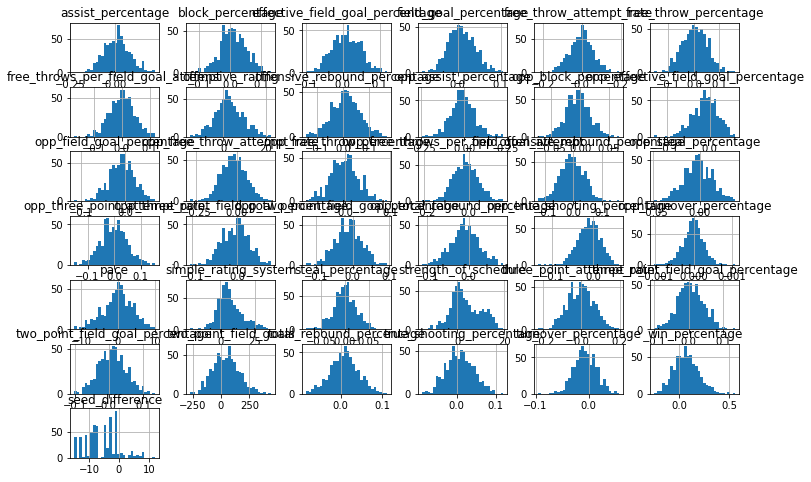

In [34]:
features_differentials.hist(bins=30, figsize=(12, 8))
#looking at the histrograms, the features all roughly follow a normal distribution

<AxesSubplot:>

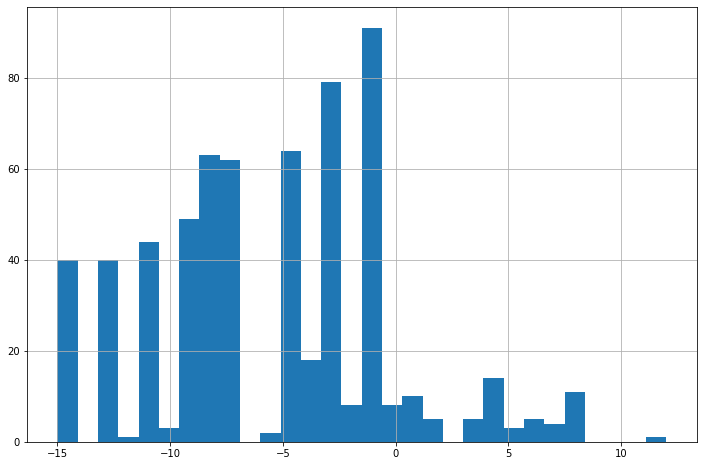

In [35]:
#Only feature that is not normally distributed, which the skewness makes sense because the home team(usally the lower seed/better team) is more likely to advance and play more games in the tournament
features_differentials['seed_difference'].hist(bins=30, figsize=(12, 8))

In [36]:
features_differentials['seed_difference'].describe()

count    630.000000
mean      -5.569841
std        5.261739
min      -15.000000
25%       -9.000000
50%       -5.000000
75%       -2.000000
max       12.000000
Name: seed_difference, dtype: float64

<AxesSubplot:>

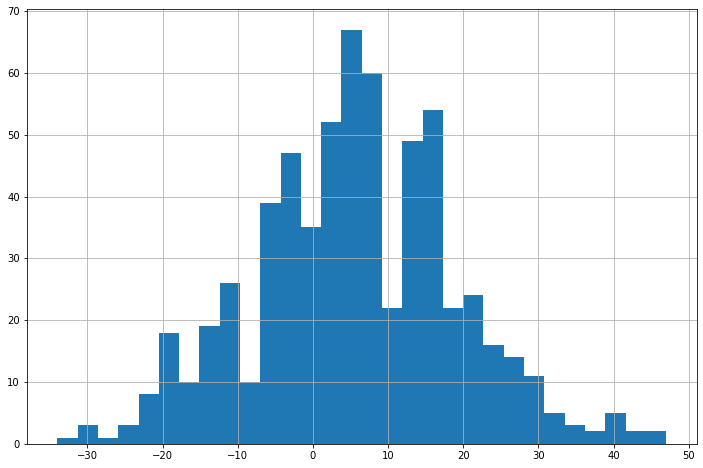

In [37]:
#Confirming reponse(score difference) makes sense and show mainly close games
response.hist(bins=30, figsize=(12, 8))

{'whiskers': [<matplotlib.lines.Line2D at 0x1b5f08d5be0>,
 'caps': [<matplotlib.lines.Line2D at 0x1b5ef575bb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b5f0838a30>],
 'medians': [<matplotlib.lines.Line2D at 0x1b5f0a0c670>],
 'fliers': [<matplotlib.lines.Line2D at 0x1b5ee999c40>],
 'means': []}

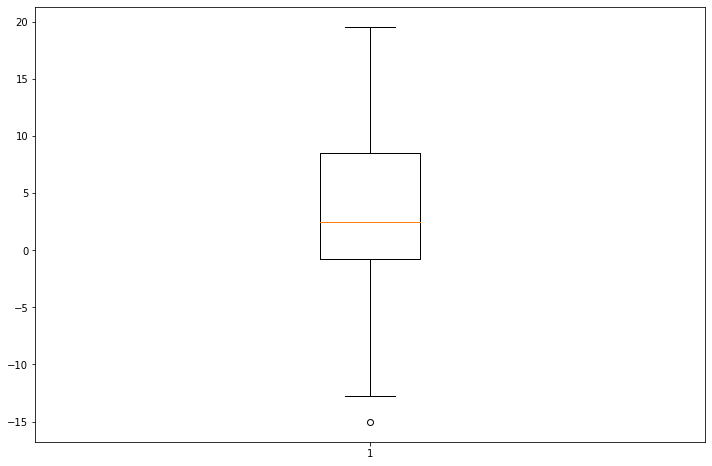

In [38]:
fig = plt.figure(figsize =(12, 8))
 
# Creating plot
plt.boxplot(features_differentials['strength_of_schedule'])

#Scaling might make sense because features reflecting % difference on diffete scale than features such as strength of schedule with much higher difference

## High level and brief look into significance and correlation of possible features to be used

In [39]:
#Using Linear Regression for a quick peek at coefficients if current feature set is used in the regression

initial_model = LinearRegression()

initial_model.fit(features_differentials, response)

print('coefficients:', initial_model.coef_)

coefficients: [-1.33607618e+01  3.22644002e-01  2.93523402e+02 -6.16955601e+02
  1.08753896e+02  5.05948140e+01 -1.10691725e+02 -9.01442385e-01
  1.58029176e+02 -6.02907253e+00  9.46155653e+00 -9.46357446e+02
  3.18007344e+02 -1.69773439e+02 -1.49978144e+02  1.52682540e+02
 -1.41696441e+02 -2.91429095e+01  6.56152316e+01  7.35410643e+01
  4.95037445e+01 -5.02749370e+03  5.59350057e+02  1.84273052e+03
 -1.10859128e+00  3.14594756e-01  2.77665443e+01  7.04248532e-01
  6.99537143e+00  9.83687502e+01  1.15923815e+02  9.65019465e-02
 -5.28740809e+03  2.07483512e+02 -1.15353377e+01  1.21708795e+01
  4.61385685e-01]


<function matplotlib.pyplot.show(close=None, block=None)>

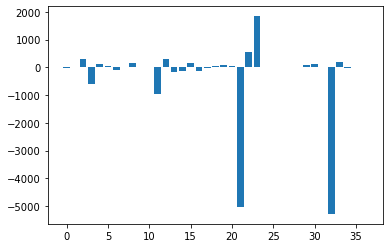

In [40]:
#Using coefficients to get a rough view of feature importance
LinReg_importance = initial_model.coef_
plt.bar([x for x in range(len(LinReg_importance))],LinReg_importance)
plt.show

In [41]:
OLS(response,features_differentials).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.606
Model:                            OLS   Adj. R-squared (uncentered):              0.581
Method:                 Least Squares   F-statistic:                              24.62
Date:                Sat, 23 Apr 2022   Prob (F-statistic):                    4.82e-96
Time:                        21:30:36   Log-Likelihood:                         -2285.9
No. Observations:                 630   AIC:                                      4646.
Df Residuals:                     593   BIC:                                      4810.
Df Model:                          37                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
assist_percentage                        -13.5106      6.447     -2.096      0.037     -26.172      -0.849
block_percentage                           0.1451     15.114      0.010      0.992     -29.538      29.828
effective_field_goal_percentage          284.6147    525.781      0.541      0.588    -748.004    1317.233
field_goal_percentage                   -601.3151    499.300     -1.204      0.229   -1581.927     379.297
free_throw_attempt_rate                  111.6183    112.941      0.988      0.323    -110.194     333.431
free_throw_percentage                     52.4844     58.206      0.902      0.368     -61.830     166.799
free_throws_per_field_goal_attempt      -115.8065    176.829     -0.655      0.513    -463.094     231.481
offensive_rating                          -0.8429      0.916     -0.920      0.358      -2.641       0.956
offensive_rebound_percentage             150.5522     93.097      1.617      0.106     -32.288     333.392
opp_assist_percentage                     -5.9503      8.278     -0.719      0.473     -22.208      10.307
opp_block_percentage                      11.5401     22.581      0.511      0.610     -32.808      55.888
opp_effective_field_goal_percentage     -984.9155    518.665     -1.899      0.058   -2003.559      33.728
opp_field_goal_percentage                367.2397    552.470      0.665      0.506    -717.795    1452.275
opp_free_throw_attempt_rate             -169.7085    168.485     -1.007      0.314    -500.609     161.192
opp_free_throw_percentage               -149.8185     77.593     -1.931      0.054    -302.209       2.572
opp_free_throws_per_field_goal_attempt   153.4094    257.187      0.596      0.551    -351.699     658.518
opp_offensive_rebound_percentage        -137.0293     77.838     -1.760      0.079    -289.900      15.842
opp_steal_percentage                     -28.4637     44.555     -0.639      0.523    -115.969      59.042
opp_three_point_attempt_rate              73.3286     87.430      0.839      0.402     -98.381     245.038
opp_three_point_field_goal_percentage     78.5765     86.510      0.908      0.364     -91.326     248.479
opp_two_point_field_goal_percentage       46.2667    133.233      0.347      0.729    -215.400     307.933
opp_total_rebound_percentage           -4775.4105   6844.410     -0.698      0.486   -1.82e+04    8666.822
opp_true_shooting_percentage             556.0650    376.553      1.477      0.140    -183.476    1295.606
opp_turnover_percentage                 1817.9955   5063.455      0.359      0.720   -8126.492    1.18e+04
pace                                      -1.1033      0.149     -7.423      0.000      -1.395 

<AxesSubplot:>

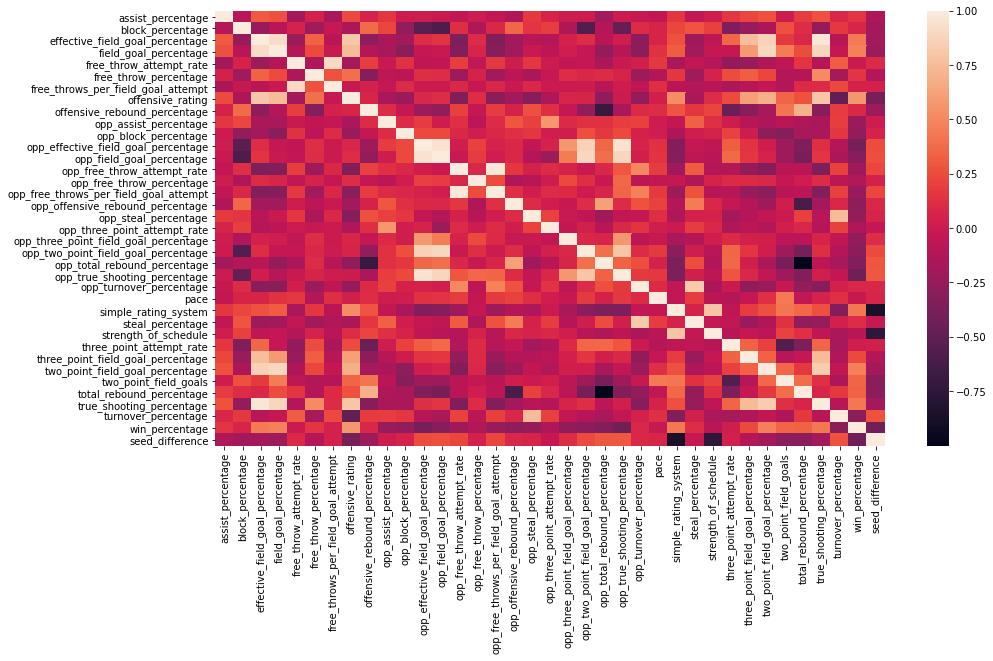

In [42]:
#Correlation plot involving all current features
plt.figure(figsize = (15,8))
sns.heatmap(features_differentials.corr())

## Focusing on features involving data on offense

In [43]:
features_differentials_offense = features_differentials[['assist_percentage',
                                      'effective_field_goal_percentage', 
                                      'field_goal_percentage', 'free_throw_attempt_rate', 'free_throw_percentage',
                                      'free_throws_per_field_goal_attempt', 
                                      'offensive_rating', 'offensive_rebound_percentage',
                                      'pace', 'three_point_attempt_rate',
                                      'three_point_field_goal_percentage',
                                      'two_point_field_goal_percentage',
                                      'true_shooting_percentage']]

OLS(response,features_differentials_offense).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.245
Model:                            OLS   Adj. R-squared (uncentered):              0.229
Method:                 Least Squares   F-statistic:                              15.37
Date:                Sat, 23 Apr 2022   Prob (F-statistic):                    2.17e-30
Time:                        21:30:43   Log-Likelihood:                         -2490.8
No. Observations:                 630   AIC:                                      5008.
Df Residuals:                     617   BIC:                                      5065.
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
assist_percentage                    -15.8171      7.888     -2.005      0.045     -31.308      -0.326
effective_field_goal_percentage     -579.3802    656.698     -0.882      0.378   -1869.015     710.254
field_goal_percentage                576.9386    639.549      0.902      0.367    -679.017    1832.894
free_throw_attempt_rate              -29.4427    145.340     -0.203      0.840    -314.863     255.978
free_throw_percentage                 -3.5894     76.755     -0.047      0.963    -154.323     147.144
free_throws_per_field_goal_attempt    20.3267    222.509      0.091      0.927    -416.640     457.294
offensive_rating                       1.1227      0.166      6.762      0.000       0.797       1.449
offensive_rebound_percentage          37.2494     14.215      2.620      0.009       9.333      65.166
pace                                  -0.3225      0.133     -2.429      0.015      -0.583      -0.062
three_point_attempt_rate             106.9348    112.602      0.950      0.343    -114.195     328.065
three_point_field_goal_percentage     95.8262     99.863      0.960      0.338    -100.286     291.938
two_point_field_goal_percentage       21.2871    149.214      0.143      0.887    -271.742     314.317
true_shooting_percentage             -83.7715    420.809     -0.199      0.842    -910.162     742.619
==============================================================================
Omnibus:                        0.532   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.766   Jarque-Bera (JB):                0.389
Skew:                           0.040   Prob(JB):                        0.823
Kurtosis:                       3.092   Cond. No.                     1.26e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<AxesSubplot:>

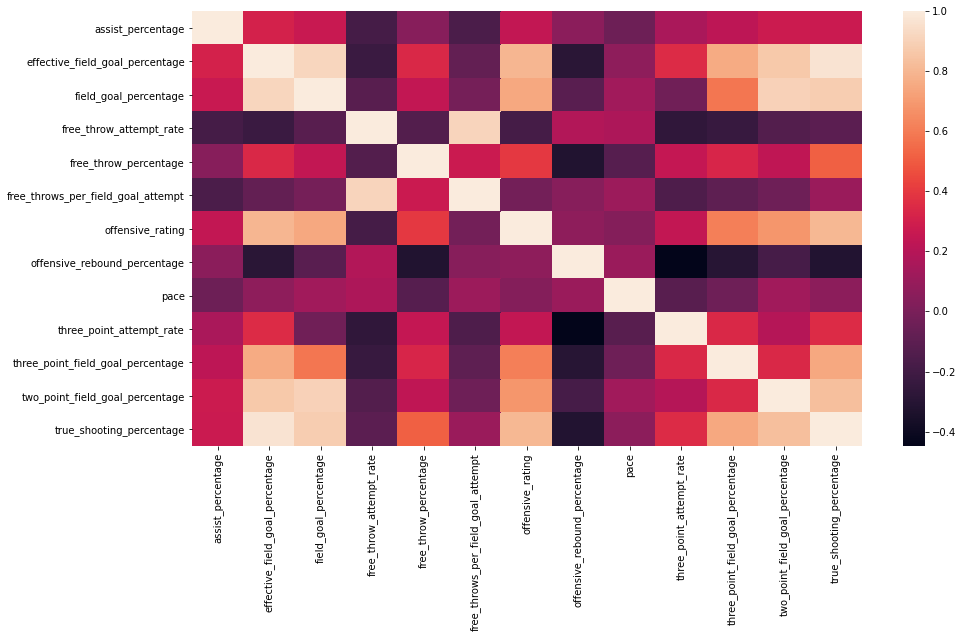

In [44]:
#Correlation plot involving all offensive features
plt.figure(figsize = (15,8))
sns.heatmap(features_differentials_offense.corr())

## Focusing on features involving data on defense

In [45]:
features_differentials_defense = features_differentials[['block_percentage', 
                                      'opp_assist_percentage',
                                      'opp_block_percentage',
                                      'opp_effective_field_goal_percentage','opp_field_goal_percentage',
                                      'opp_free_throw_attempt_rate', 
                                      'opp_free_throw_percentage',
                                      'opp_free_throws_per_field_goal_attempt', 
                                      'opp_offensive_rebound_percentage',
                                      'opp_steal_percentage',
                                      'opp_three_point_attempt_rate','opp_three_point_field_goal_percentage',
                                      'opp_two_point_field_goal_percentage','opp_total_rebound_percentage',
                                      'opp_true_shooting_percentage', 'opp_turnover_percentage',
                                      'steal_percentage']]
OLS(response,features_differentials_defense).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.259
Model:                            OLS   Adj. R-squared (uncentered):              0.238
Method:                 Least Squares   F-statistic:                              12.57
Date:                Sat, 23 Apr 2022   Prob (F-statistic):                    2.25e-30
Time:                        21:30:48   Log-Likelihood:                         -2484.9
No. Observations:                 630   AIC:                                      5004.
Df Residuals:                     613   BIC:                                      5079.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
block_percentage                          23.3786     19.317      1.210      0.227     -14.557      61.314
opp_assist_percentage                     -8.6142     10.212     -0.844      0.399     -28.668      11.440
opp_block_percentage                      29.5726     27.069      1.092      0.275     -23.587      82.732
opp_effective_field_goal_percentage     -608.2020    661.480     -0.919      0.358   -1907.244     690.840
opp_field_goal_percentage               -431.8069    710.826     -0.607      0.544   -1827.756     964.142
opp_free_throw_attempt_rate             -447.3955    218.971     -2.043      0.041    -877.420     -17.371
opp_free_throw_percentage               -219.4898    100.809     -2.177      0.030    -417.462     -21.517
opp_free_throws_per_field_goal_attempt   510.8092    330.982      1.543      0.123    -139.187    1160.805
opp_offensive_rebound_percentage          39.2037     20.883      1.877      0.061      -1.807      80.214
opp_steal_percentage                    -211.8354     38.049     -5.567      0.000    -286.557    -137.113
opp_three_point_attempt_rate             -50.8714    112.898     -0.451      0.652    -272.585     170.842
opp_three_point_field_goal_percentage    194.6839    113.402      1.717      0.087     -28.019     417.387
opp_two_point_field_goal_percentage      382.9942    171.322      2.236      0.026      46.544     719.444
opp_total_rebound_percentage            -148.2268     23.001     -6.444      0.000    -193.396    -103.057
opp_true_shooting_percentage             484.3657    431.214      1.123      0.262    -362.470    1331.201
opp_turnover_percentage                 3744.2056   3896.346      0.961      0.337   -3907.601    1.14e+04
steal_percentage                          98.4518     44.416      2.217      0.027      11.226     185.677
==============================================================================
Omnibus:                        3.206   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                3.026
Skew:                           0.140   Prob(JB):                        0.220
Kurtosis:                       3.192   Cond. No.                         782.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

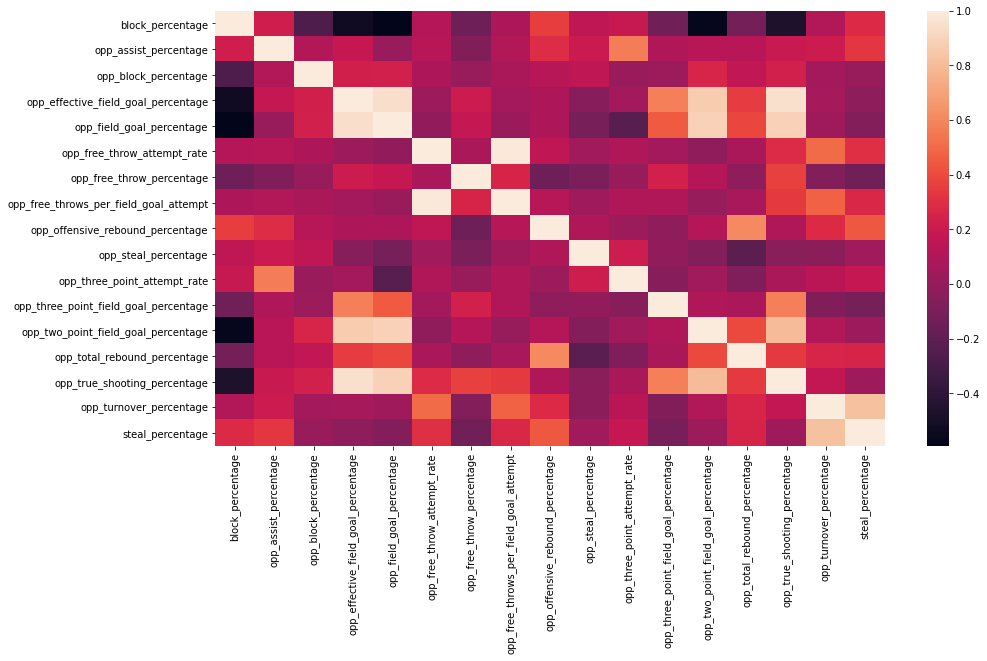

In [46]:
#Correlation plot involving all defensive features
plt.figure(figsize = (15,8))
sns.heatmap(features_differentials_defense.corr())

## Feature Selection

- Anything with significance under .5 and most signficant representing groups with high correlation(ex:effective_field_goal_percentage over true_shooting_percentage )
- Removed from defense: 'opp_effective_field_goal_percentage','opp_field_goal_percentage',opp_turnover_percentage,'opp_three_point_attempt_rate',
- Removed from offense: 'effective_field_goal_percentage','field_goal_percentage','free_throw_attempt_rate', 'free_throw_percentage','free_throws_per_field_goal_attempt', 'true_shooting_percentage',
- Keeping 'two_point_field_goal_percentage' from offense to be consistent with defense features ('opp_two_point_field_goal_percentage')

In [47]:
features_differentials_final = features_differentials[['assist_percentage', 'block_percentage',  
                                      'offensive_rating', 'offensive_rebound_percentage',
                                      'opp_assist_percentage',
                                      'opp_block_percentage',
                                      'opp_free_throw_attempt_rate', 
                                      'opp_free_throw_percentage',
                                      'opp_free_throws_per_field_goal_attempt', 
                                      'opp_offensive_rebound_percentage',
                                      'opp_steal_percentage',
                                      'opp_three_point_field_goal_percentage',
                                      'opp_two_point_field_goal_percentage','opp_total_rebound_percentage',
                                      'opp_true_shooting_percentage', 
                                      'pace', 'simple_rating_system', 'steal_percentage',
                                      'strength_of_schedule', 'three_point_attempt_rate',
                                      'three_point_field_goal_percentage',
                                      'two_point_field_goal_percentage', 
                                      'true_shooting_percentage',
                                      'turnover_percentage','win_percentage','seed_difference']]
features_differentials_final

,assist_percentage,block_percentage,offensive_rating,offensive_rebound_percentage,opp_assist_percentage,opp_block_percentage,opp_free_throw_attempt_rate,opp_free_throw_percentage,opp_free_throws_per_field_goal_attempt,opp_offensive_rebound_percentage,...,simple_rating_system,steal_percentage,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,true_shooting_percentage,turnover_percentage,win_percentage,seed_difference
0,-0.089,0.088,7.6,-0.039,0.042,-0.022,0.034,0.014,0.027,0.026,...,6.58,-0.027,6.25,0.071,0.068,0.044,0.068,0.009,0.028,-8
1,-0.228,0.104,2.3,0.036,-0.112,-0.017,-0.071,-0.002,-0.049,0.038,...,14.26,-0.013,11.40,-0.070,0.015,0.012,0.013,0.010,0.020,-11
2,0.015,0.019,8.7,-0.058,0.010,-0.025,0.081,0.002,0.056,-0.050,...,6.93,0.013,-4.16,0.007,0.104,0.010,0.068,-0.012,0.215,-3
3,0.020,-0.033,-8.9,-0.099,0.016,0.007,0.006,-0.008,0.001,-0.047,...,-10.84,0.009,-4.13,0.069,-0.043,0.039,0.010,0.030,-0.007,4
4,-0.002,-0.067,-3.7,-0.100,-0.010,0.020,-0.123,-0.022,-0.093,-0.065,...,-5.51,0.006,-5.20,0.076,-0.018,0.017,0.014,-0.001,0.084,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.013,-0.004,-4.9,0.020,-0.028,-0.002,0.074,0.040,0.063,0.014,...,-1.41,0.030,-2.71,0.056,-0.060,0.011,-0.022,0.018,0.031,-1
626,0.043,0.003,0.5,0.041,0.106,0.012,-0.047,0.045,-0.020,0.021,...,14.01,0.009,11.67,-0.005,0.025,-0.052,-0.008,0.001,-0.063,-8
627,0.057,-0.035,13.9,-0.065,0.017,-0.001,-0.072,0.000,-0.052,0.024,...,14.22,-0.001,5.56,0.108,0.090,0.057,0.096,-0.008,0.104,-9
628,-0.031,-0.036,-2.3,-0.048,-0.096,0.028,-0.081,-0.034,-0.066,-0.019,...,3.95,-0.037,4.88,-0.049,0.008,-0.019,-0.018,-0.024,0.018,-7


In [48]:
#Making sure the team names and years of games are combined with the same team statistic differentials before train/test split 
pre_training_features = pd.concat([features_differentials_final,game_info], axis=1)
pre_training_features

,assist_percentage,block_percentage,offensive_rating,offensive_rebound_percentage,opp_assist_percentage,opp_block_percentage,opp_free_throw_attempt_rate,opp_free_throw_percentage,opp_free_throws_per_field_goal_attempt,opp_offensive_rebound_percentage,...,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,true_shooting_percentage,turnover_percentage,win_percentage,seed_difference,Year,Home_Team,Away_Team
0,-0.089,0.088,7.6,-0.039,0.042,-0.022,0.034,0.014,0.027,0.026,...,0.071,0.068,0.044,0.068,0.009,0.028,-8,2010,Baylor,Old Dominion
1,-0.228,0.104,2.3,0.036,-0.112,-0.017,-0.071,-0.002,-0.049,0.038,...,-0.070,0.015,0.012,0.013,0.010,0.020,-11,2010,Baylor,Sam Houston State
2,0.015,0.019,8.7,-0.058,0.010,-0.025,0.081,0.002,0.056,-0.050,...,0.007,0.104,0.010,0.068,-0.012,0.215,-3,2010,Brigham Young,Florida
3,0.020,-0.033,-8.9,-0.099,0.016,0.007,0.006,-0.008,0.001,-0.047,...,0.069,-0.043,0.039,0.010,0.030,-0.007,4,2010,Butler,Duke
4,-0.002,-0.067,-3.7,-0.100,-0.010,0.020,-0.123,-0.022,-0.093,-0.065,...,0.076,-0.018,0.017,0.014,-0.001,0.084,3,2010,Butler,Kansas State
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,0.013,-0.004,-4.9,0.020,-0.028,-0.002,0.074,0.040,0.063,0.014,...,0.056,-0.060,0.011,-0.022,0.018,0.031,-1,2019,Virginia Commonwealth,Central Florida
626,0.043,0.003,0.5,0.041,0.106,0.012,-0.047,0.045,-0.020,0.021,...,-0.005,0.025,-0.052,-0.008,0.001,-0.063,-8,2019,Virginia Tech,Liberty
627,0.057,-0.035,13.9,-0.065,0.017,-0.001,-0.072,0.000,-0.052,0.024,...,0.108,0.090,0.057,0.096,-0.008,0.104,-9,2019,Virginia Tech,Saint Louis
628,-0.031,-0.036,-2.3,-0.048,-0.096,0.028,-0.081,-0.034,-0.066,-0.019,...,-0.049,0.008,-0.019,-0.018,-0.024,0.018,-7,2019,Wisconsin,Oregon


# Create training set

In [49]:
#Create training(75%) and test(25%) data
X_train, X_test, y_train, y_test = train_test_split(pre_training_features,response,random_state=42)

game_info_train = X_train[['Year','Home_Team','Away_Team']]
game_info_test = X_test[['Year','Home_Team','Away_Team']]

#This data below will not be needed in model making but used later for result analysis using the above game_info DataFrames
X_train=X_train.drop(columns=['Year','Home_Team','Away_Team'])
X_test=X_test.drop(columns=['Year','Home_Team','Away_Team'])

# Scale the data

In [50]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creating benchmark feature sets

## Better Seed Benchmark

In [51]:
#Only input feature is seed differential, with the assumption that better seed will win in each prediction
X_train_BetterSeed = X_train[['seed_difference']]
X_train_BetterSeed_Scaled = scaler.fit_transform(X_train_BetterSeed)

X_test_BetterSeed = X_test[['seed_difference']]
X_test_BetterSeed_Scaled = scaler.transform(X_test_BetterSeed)

## Better Record Benchmark

In [52]:
#Similar to seed_differential benchmark, but teams with worse seeds can still have better records than teams with better seeds
X_train_BetterRecord = X_train[['win_percentage']]
X_train_BetterRecord_Scaled = scaler.fit_transform(X_train_BetterRecord)

X_test_BetterRecord = X_test[['win_percentage']]
X_test_BetterRecord_Scaled = scaler.transform(X_test_BetterRecord)

# Using PCA (Scaled & Not-Scaled)

## Not scaled

In [53]:
pca = PCA(.95)
pca.fit(X_train)
pca.n_components_

4

In [54]:
X_train_PCA = pca.transform(X_train)
X_test_PCA = pca.transform(X_test)

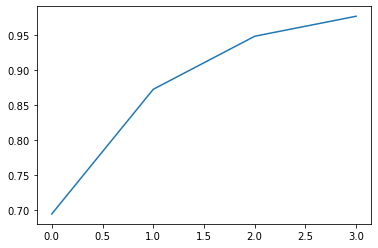

In [55]:
plt.plot(pca.explained_variance_ratio_.cumsum())

## Scaled

In [56]:
pca_scaled = PCA(.95)
pca_scaled.fit(X_train_scaled)
pca_scaled.n_components_

15

In [57]:
X_train_scaled_PCA = pca_scaled.transform(X_train_scaled)
X_test_scaled_PCA = pca_scaled.transform(X_test_scaled)

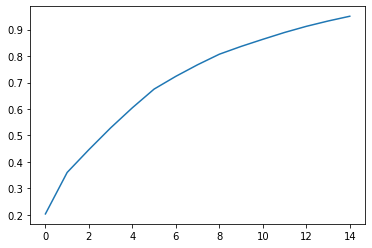

In [58]:
plt.plot(pca_scaled.explained_variance_ratio_.cumsum())

# Run benchmark models using Linear Regression

## Better Seed Benchmark Model

In [59]:
#Not scaled BetterSeed Model, find MSE
BetterSeed_BenchmarkModel = LinearRegression()

BetterSeed_BenchmarkModel.fit(X_train_BetterSeed, y_train)

y_pred_BetterSeed = BetterSeed_BenchmarkModel.predict(X_test_BetterSeed)

mse_BetterSeed = mean_squared_error(y_test, y_pred_BetterSeed)

#Scaled BetterSeed Model, find MSE
BetterSeed_BenchmarkModel_Scaled = LinearRegression()

BetterSeed_BenchmarkModel_Scaled.fit(X_train_BetterSeed_Scaled, y_train)

y_pred_BetterSeed_Scaled = BetterSeed_BenchmarkModel_Scaled.predict(X_test_BetterSeed_Scaled)

mse_BetterSeed_Scaled = mean_squared_error(y_test, y_pred_BetterSeed_Scaled)

## Better Record Benchmark Model

In [60]:
#Not scaled BetterRecord Model, find MSE
BetterRecord_BenchmarkModel = LinearRegression()

BetterRecord_BenchmarkModel.fit(X_train_BetterRecord, y_train)

y_pred_BetterRecord = BetterSeed_BenchmarkModel.predict(X_test_BetterRecord)

mse_BetterRecord = mean_squared_error(y_test, y_pred_BetterRecord)

#Scaled BetterRecord Model, find MSE
BetterRecord_BenchmarkModel_Scaled = LinearRegression()

BetterRecord_BenchmarkModel_Scaled.fit(X_train_BetterRecord_Scaled, y_train)

y_pred_BetterRecord_Scaled = BetterRecord_BenchmarkModel_Scaled.predict(X_test_BetterRecord_Scaled)

mse_BetterRecord_Scaled = mean_squared_error(y_test, y_pred_BetterRecord_Scaled)

# Perform Grid Searches 

## Perform Individual Model Grid Searches

### GradientBoostingRegressor GridSearch

In [61]:
# -----
# Coarse-Grained GradientBoostingRegressor GridSearch
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'n_estimators': list(range(100, 1000, 100)),'learning_rate': [.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 792 candidates, totalling 2376 fits
The best parameters are:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 600}


In [60]:
# -----
# Refined GradientBoostingRegressor GridSearch
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [1,2], 'n_estimators': list(range(500, 700, 50)),'learning_rate': [.005,.01,.015]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
The best parameters are:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 550}


In [38]:
# -----
# Final GradientBoostingRegressor GridSearch
#   Repeated search to make sure that optimal hyperparameter values found are indeed optimal
# -----

param_grid={'max_depth': [1,2], 'n_estimators': list(range(500, 600, 25)),'learning_rate': [.005,.01,.015]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
The best parameters are:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 550}


On this dataset, the optimal model parameters for the `GradientBoostingRegressor` class are:

- `learning_rate = 0.01`
- `max_depth = 1`
- `n_estimators = 550`

### GradientBoostingRegressor GridSearch w/Scaling

In [32]:
# -----
# Coarse-Grained GradientBoostingRegressor GridSearch with Scaled features
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'n_estimators': list(range(100, 1000, 100)),'learning_rate': [.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 792 candidates, totalling 2376 fits
The best parameters are:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 600}


In [33]:
# -----
# Refined GradientBoostingRegressor GridSearch with Scaled features
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [1,2], 'n_estimators': list(range(500, 700, 50)),'learning_rate': [.005,.01,.015]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
The best parameters are:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 600}


In [34]:
# -----
# Final GradientBoostingRegressor GridSearch with Scaled features
#   Repeated search to make sure that optimal hyperparameter values found are indeed optimal
# -----

param_grid={'max_depth': [1,2], 'n_estimators': list(range(550, 650, 25)),'learning_rate': [.005,.01,.015]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
The best parameters are:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 600}


On this dataset, the optimal model parameters for the `GradientBoostingRegressor` class w/Scaling are:

- `learning_rate = 0.01`
- `max_depth = 1`
- `n_estimators = 600`

### GradientBoostingRegressor GridSearch PCA

In [32]:
# -----
# Coarse-Grained GradientBoostingRegressor GridSearch with PCA
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'n_estimators': list(range(100, 1000, 100)),'learning_rate': [.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 792 candidates, totalling 2376 fits
The best parameters are:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 600}


In [33]:
# -----
# Refined GradientBoostingRegressor GridSearch with PCA
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [1,2], 'n_estimators': list(range(500, 700, 50)),'learning_rate': [.005,.01,.015]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
The best parameters are:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 550}


In [34]:
# -----
# Final GradientBoostingRegressor GridSearch with PCA
#   Repeated search to make sure that optimal hyperparameter values found are indeed optimal
# -----

param_grid={'max_depth': [1,2], 'n_estimators': list(range(500, 600, 25)),'learning_rate': [.005,.01,.015]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
The best parameters are:  {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 550}


On this dataset, the optimal model parameters for the `GradientBoostingRegressor` class PCA are:

- `learning_rate = 0.01`
- `max_depth = 1`
- `n_estimators = 550`

### GradientBoostingRegressor GridSearch PCA w/Scaling

In [35]:
# -----
# Coarse-Grained GradientBoostingRegressor GridSearch with PCA & Scaled features
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'n_estimators': list(range(100, 1000, 100)),'learning_rate': [.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 792 candidates, totalling 2376 fits
The best parameters are:  {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}


In [36]:
# -----
# Refined GradientBoostingRegressor GridSearch with PCA & Scaled features
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [1,2], 'n_estimators': list(range(50, 150, 50)),'learning_rate': [.05,.1,.15]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameters are:  {'learning_rate': 0.15, 'max_depth': 1, 'n_estimators': 100}


In [37]:
# -----
# Final GradientBoostingRegressor GridSearch with PCA & Scaled features
#   Repeated search to make sure that optimal hyperparameter values found are indeed optimal
# -----

param_grid={'max_depth': [1,2], 'n_estimators': list(range(75, 125, 25)),'learning_rate': [.125,.15,.175]}
classifier = GradientBoostingRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameters are:  {'learning_rate': 0.15, 'max_depth': 1, 'n_estimators': 100}


On this dataset, the optimal model parameters for the `GradientBoostingRegressor` class PCA w/Scaling are:

- `learning_rate = 0.15`
- `max_depth = 1`
- `n_estimators = 100`

### RandomForestRegressor GridSearch

In [62]:
# -----
# Coarse-Grained RandomForestRegressor GridSearch
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'n_estimators': list(range(100, 1000, 100)),'min_samples_split': list(range(2, 20, 3))}
classifier = RandomForestRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
The best parameters are:  {'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 200}


In [37]:
# -----
# Refined RandomForestRegressor GridSearch
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [3,4,5], 'n_estimators': list(range(100, 300, 50)),'min_samples_split': list(range(2, 3, 1))}
classifier = RandomForestRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameters are:  {'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 200}


On this dataset, the optimal model parameters for the `RandomForestRegressor` class are:

- `max_depth = 4`
- `n_estimators = 200`
- `min_samples_split = 2`

### RandomForestRegressor GridSearch w/Scaling

In [51]:
# -----
# Coarse-Grained RandomForestRegressor GridSearch with Scaled features
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'n_estimators': list(range(100, 1000, 100)),'min_samples_split': list(range(2, 20, 3))}
classifier = RandomForestRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
The best parameters are:  {'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 200}


In [39]:
# -----
# Refined RandomForestRegressor GridSearch with Scaled features
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [3,4,5], 'n_estimators': list(range(100, 300, 50)),'min_samples_split': list(range(4, 6, 1))}
classifier = RandomForestRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
The best parameters are:  {'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 200}


On this dataset, the optimal model parameters for the `RandomForestRegressor` class w/Scaling are:

- `max_depth = 4`
- `n_estimators = 200`
- `min_samples_split = 5`

### RandomForestRegressor GridSearch PCA

In [38]:
# -----
# Coarse-Grained RandomForestRegressor GridSearch with PCA
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'n_estimators': list(range(100, 1000, 100)),'min_samples_split': list(range(2, 20, 3))}
classifier = RandomForestRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
The best parameters are:  {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [40]:
# -----
# Refined RandomForestRegressor GridSearch with PCA
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [1,2,3], 'n_estimators': list(range(50, 150, 50)),'min_samples_split': list(range(2, 3, 1))}
classifier = RandomForestRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
The best parameters are:  {'max_depth': 2, 'min_samples_split': 2, 'n_estimators': 100}


On this dataset, the optimal model parameters for the `RandomForestRegressor` class PCA are:

- `max_depth = 2`
- `n_estimators = 100`
- `min_samples_split = 2`

### RandomForestRegressor GridSearch PCA w/Scaling

In [41]:
# -----
# Coarse-Grained RandomForestRegressor GridSearch with PCA & Scaled features
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'n_estimators': list(range(100, 1000, 100)),'min_samples_split': list(range(2, 20, 3))}
classifier = RandomForestRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
The best parameters are:  {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 900}


In [42]:
# -----
# Refined RandomForestRegressor GridSearch with PCA & Scaled features
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [7,8,9], 'n_estimators': list(range(850, 950, 50)),'min_samples_split': list(range(4, 6, 1))}
classifier = RandomForestRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameters are:  {'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 900}


On this dataset, the optimal model parameters for the `RandomForestRegressor` class PCA w/Scaling are:

- `max_depth = 7`
- `n_estimators = 900`
- `min_samples_split = 5`

### DecisionTreeRegressor GridSearch

In [43]:
# -----
# Coarse-Grained DecisionTreeRegressor GridSearch
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'splitter' : ["best", "random"],'min_samples_split': list(range(2, 20, 3))}
classifier = DecisionTreeRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
The best parameters are:  {'max_depth': 3, 'min_samples_split': 14, 'splitter': 'best'}


In [44]:
# -----
# Refined DecisionTreeRegressor GridSearch
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [2,3,4], 'splitter' : ["best", "random"],'min_samples_split': list(range(13, 15, 1))}
classifier = DecisionTreeRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameters are:  {'max_depth': 3, 'min_samples_split': 13, 'splitter': 'best'}


On this dataset, the optimal model parameters for the `DecisionTreeRegressor` class are:

- `splitter = 'best`
- `max_depth = 3`
- `min_samples_split = 13`

### DecisionTreeRegressor GridSearch w/Scaling

In [37]:
# -----
# Coarse-Grained DecisionTreeRegressor GridSearch with Scaled features
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'splitter' : ["best", "random"],'min_samples_split': list(range(2, 20, 3))}
classifier = DecisionTreeRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
The best parameters are:  {'max_depth': 3, 'min_samples_split': 14, 'splitter': 'best'}


In [38]:
# -----
# Refined DecisionTreeRegressor GridSearch with Scaled features
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [2,3,4], 'splitter' : ["best", "random"],'min_samples_split': list(range(13, 15, 1))}
classifier = DecisionTreeRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameters are:  {'max_depth': 3, 'min_samples_split': 13, 'splitter': 'best'}


On this dataset, the optimal model parameters for the `DecisionTreeRegressor` class w/Scaling are:

- `splitter = 'best`
- `max_depth = 3`
- `min_samples_split = 13`

### DecisionTreeRegressor GridSearch PCA

In [47]:
# -----
# Coarse-Grained DecisionTreeRegressor GridSearch with PCA features
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'splitter' : ["best", "random"],'min_samples_split': list(range(2, 20, 3))}
classifier = DecisionTreeRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
The best parameters are:  {'max_depth': 5, 'min_samples_split': 17, 'splitter': 'random'}


In [48]:
# -----
# Refined DecisionTreeRegressor GridSearch with PCA features
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [5,6,7], 'splitter' : ["best", "random"],'min_samples_split': list(range(15, 20, 1))}
classifier = DecisionTreeRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
The best parameters are:  {'max_depth': 6, 'min_samples_split': 18, 'splitter': 'random'}


On this dataset, the optimal model parameters for the `DecisionTreeRegressor` class PCA are:

- `splitter = 'random`
- `max_depth = 6`
- `min_samples_split = 18`

### DecisionTreeRegressor GridSearch PCA w/Scaling

In [49]:
# -----
# Coarse-Grained DecisionTreeRegressor GridSearch with PCA & Scaled features
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'max_depth': [1,2,3,4,5,8,16,32], 'splitter' : ["best", "random"],'min_samples_split': list(range(2, 20, 3))}
classifier = DecisionTreeRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
The best parameters are:  {'max_depth': 3, 'min_samples_split': 2, 'splitter': 'random'}


In [40]:
# -----
# Refined DecisionTreeRegressor GridSearch with PCA & Scaled features
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'max_depth': [2,3,4], 'splitter' : ["best", "random"],'min_samples_split': list(range(2, 3, 1))}
classifier = DecisionTreeRegressor(random_state=42)
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled_PCA, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
The best parameters are:  {'max_depth': 3, 'min_samples_split': 2, 'splitter': 'random'}


On this dataset, the optimal model parameters for the `DecisionTreeRegressor` class PCA w/Scaling are:

- `splitter = 'random`
- `max_depth = 3`
- `min_samples_split = 2`

### K-Neighbors GridSearch

In [97]:
# -----
# Coarse-Grained KNeighborsRegressor GridSearch
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'n_neighbors': [11,21,31,41,51], 'weights' : ["uniform", "distance"],'metric': ["euclidean", "manhattan"]}
classifier = KNeighborsRegressor()
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
The best parameters are:  {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'}


In [99]:
# -----
# Refined KNeighborsRegressor GridSearch
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'n_neighbors': [17,19,21,23], 'weights' : ["uniform", "distance"],'metric': ["euclidean", "manhattan"]}
classifier = KNeighborsRegressor()
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
The best parameters are:  {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


On this dataset, the optimal model parameters for the `KNeighborsRegressor` class are:

- `metric = 'manhattan`
- `n_neighbors = 19`
- `weights = 'distance`

### K-Neighbors Scaled GridSearch

In [100]:
# -----
# Coarse-Grained KNeighborsRegressor GridSearch with scaled features
#   Wide search based on hyperparameter ranges provided
# -----

param_grid={'n_neighbors': [11,21,31,41,51], 'weights' : ["uniform", "distance"],'metric': ["euclidean", "manhattan"]}
classifier = KNeighborsRegressor()
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
The best parameters are:  {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


In [41]:
# -----
# Refined KNeighborsRegressor GridSearch with scaled features
#   Smaller window search based on optimal hyperparameter values found in initial broad search
# -----

param_grid={'n_neighbors': [19,11,13], 'weights' : ["uniform", "distance"],'metric': ["euclidean", "manhattan"]}
classifier = KNeighborsRegressor()
grid_search_cv = GridSearchCV(estimator = classifier,param_grid=param_grid,verbose=1,cv=3)

grid_search_cv.fit(X_train_scaled, y_train)
print("The best parameters are: ", grid_search_cv.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
The best parameters are:  {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


On this dataset, the optimal model parameters for the `KNeighborsRegressor` class are:

- `metric = 'manhattan`
- `n_neighbors = 11`
- `weights = 'distance`

# Fit Optimal Models
Using the optimal parameters found in the GridSearch for each model

## GradientBoostingRegressor

In [62]:
gbrt = GradientBoostingRegressor(max_depth=1,n_estimators =550,learning_rate=.01,random_state=42)
gbrt.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=1, n_estimators=550,
                          random_state=42)

## GradientBoostingRegressor w/Scaling

In [63]:
gbrt_scaled = GradientBoostingRegressor(max_depth=1,n_estimators =600,learning_rate=.01,random_state=42)
gbrt_scaled.fit(X_train_scaled,y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=1, n_estimators=600,
                          random_state=42)

## GradientBoostingRegressor PCA

In [64]:
gbrt_PCA = GradientBoostingRegressor(max_depth=1,n_estimators =550,learning_rate=.01,random_state=42)
gbrt_PCA.fit(X_train_PCA,y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=1, n_estimators=550,
                          random_state=42)

## GradientBoostingRegressor PCA w/Scaling

In [65]:
gbrt_scaled_PCA = GradientBoostingRegressor(max_depth=1,n_estimators =100,learning_rate=.15,random_state=42)
gbrt_scaled_PCA.fit(X_train_scaled_PCA,y_train)

GradientBoostingRegressor(learning_rate=0.15, max_depth=1, random_state=42)

## RandomForestRegressor

In [66]:
rnd_reg = RandomForestRegressor(max_depth=4,n_estimators =200,min_samples_split=2,random_state=42)
rnd_reg.fit(X_train,y_train)

RandomForestRegressor(max_depth=4, n_estimators=200, random_state=42)

## RandomForestRegressor w/Scaling

In [67]:
rnd_reg_scaled = RandomForestRegressor(max_depth=4,n_estimators =200,min_samples_split=5,random_state=42)
rnd_reg_scaled.fit(X_train_scaled,y_train)

RandomForestRegressor(max_depth=4, min_samples_split=5, n_estimators=200,
                      random_state=42)

## RandomForestRegressor PCA

In [68]:
rnd_reg_PCA = RandomForestRegressor(max_depth=2,n_estimators =100,min_samples_split=2,random_state=42)
rnd_reg_PCA.fit(X_train_PCA,y_train)

RandomForestRegressor(max_depth=2, random_state=42)

## RandomForestRegressor PCA w/Scaling

In [69]:
rnd_reg_scaled_PCA = RandomForestRegressor(max_depth=7,n_estimators =900,min_samples_split=5,random_state=42)
rnd_reg_scaled_PCA.fit(X_train_scaled_PCA,y_train)

RandomForestRegressor(max_depth=7, min_samples_split=5, n_estimators=900,
                      random_state=42)

## DecisionTreeRegressor

In [70]:
tree_reg = DecisionTreeRegressor(splitter='best', max_depth=3, min_samples_split=13, random_state=42)
tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=3, min_samples_split=13, random_state=42)

## DecisionTreeRegressor w/Scaling

In [71]:
tree_reg_scaled = DecisionTreeRegressor(splitter='best', max_depth=3, min_samples_split=13, random_state=42)
tree_reg_scaled.fit(X_train_scaled,y_train)

DecisionTreeRegressor(max_depth=3, min_samples_split=13, random_state=42)

## DecisionTreeRegressor PCA

In [72]:
tree_reg_PCA = DecisionTreeRegressor(splitter='random', max_depth=6, min_samples_split=18, random_state=42)
tree_reg_PCA.fit(X_train_PCA,y_train)

DecisionTreeRegressor(max_depth=6, min_samples_split=18, random_state=42,
                      splitter='random')

## DecisionTreeRegressor PCA w/Scaling

In [73]:
tree_reg_scaled_PCA = DecisionTreeRegressor(splitter='random', max_depth=3, min_samples_split=2, random_state=42)
tree_reg_scaled_PCA.fit(X_train_scaled_PCA,y_train)

DecisionTreeRegressor(max_depth=3, random_state=42, splitter='random')

## KNeighborsRegressor

In [74]:
knn_reg = KNeighborsRegressor(metric=  'manhattan', n_neighbors= 19, weights= 'distance')
knn_reg.fit(X_train,y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=19, weights='distance')

## KNeighborsRegressor w/Scaling

In [75]:
knn_scaled_reg = KNeighborsRegressor(metric=  'manhattan', n_neighbors= 11, weights= 'distance')
knn_scaled_reg.fit(X_train,y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=11, weights='distance')

## VotingRegressor
Creating a model combining the Gradient Boosting, Random Forest, Decision Tree, and K-Nearest Neighbor Models.

In [76]:
voting_reg = VotingRegressor(
                        [('gbrt',gbrt),
                          ('rf', rnd_reg),
                          ('tree', tree_reg),
                          ('knn', knn_reg)])

voting_reg.fit(X_train,y_train)

VotingRegressor(estimators=[('gbrt',
                             GradientBoostingRegressor(learning_rate=0.01,
                                                       max_depth=1,
                                                       n_estimators=550,
                                                       random_state=42)),
                            ('rf',
                             RandomForestRegressor(max_depth=4,
                                                   n_estimators=200,
                                                   random_state=42)),
                            ('tree',
                             DecisionTreeRegressor(max_depth=3,
                                                   min_samples_split=13,
                                                   random_state=42)),
                            ('knn',
                             KNeighborsRegressor(metric='manhattan',
                                                 n_neighbors=19,
                     

# Artificial Neural Networks

In [77]:
#Split training data into smaller training set and validation set
X_train_ANN, X_valid_ANN, y_train_ANN, y_valid_ANN = train_test_split(X_train,y_train,test_size=0.25,random_state=42)

In [78]:
#Check the shape of the training sets for input shape parameter
X_train_ANN.shape
#x_test.shape

(354, 26)

In [79]:
#Run Sequential Class model with 4 layers

tf.random.set_seed(42)

model_ANN = keras.models.Sequential()
model_ANN.add(keras.layers.Flatten(input_shape=[26]))
model_ANN.add(keras.layers.Dense(1000,activation="softmax"))
model_ANN.add(keras.layers.Dense(100,activation="softmax"))
model_ANN.add(keras.layers.Dense(10,activation="softmax"))
model_ANN.add(keras.layers.Dense(1))


model_ANN.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(lr=0.01))

history = model_ANN.fit(X_train_ANN,y_train_ANN,epochs=1000,validation_data=(X_valid_ANN,y_valid_ANN))

C:\Users\gfann\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/1000
12/12 [==============================] - 1s 19ms/step - loss: 199.6507 - val_loss: 234.4536
Epoch 2/1000
12/12 [==============================] - 0s 4ms/step - loss: 189.4930 - val_loss: 224.9577
Epoch 3/1000
12/12 [==============================] - 0s 4ms/step - loss: 183.9006 - val_loss: 219.9217
Epoch 4/1000
12/12 [==============================] - 0s 4ms/step - loss: 181.3486 - val_loss: 216.7481
Epoch 5/1000
12/12 [==============================] - 0s 6ms/step - loss: 179.7345 - val_loss: 215.3087
Epoch 6/1000
12/12 [==============================] - 0s 4ms/step - loss: 179.0559 - val_loss: 213.8610
Epoch 7/1000
12/12 [==============================] - 0s 6ms/step - loss: 178.5149 - val_loss: 213.4208
Epoch 8/1000
12/12 [==============================] - 0s 5ms/step - loss: 178.4557 - val_loss: 212.6750
Epoch 9/1000
12/12 [==============================] - 0s 5ms/step - loss: 178.1884 - val_loss: 210.7381
Epoch 10/1000
12/12 [==============================] - 0s 5ms/s

12/12 [==============================] - 0s 5ms/step - loss: 178.4680 - val_loss: 209.7047
Epoch 80/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.9008 - val_loss: 209.3737
Epoch 81/1000
12/12 [==============================] - 0s 6ms/step - loss: 178.1540 - val_loss: 210.0319
Epoch 82/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8376 - val_loss: 210.0926
Epoch 83/1000
12/12 [==============================] - 0s 6ms/step - loss: 177.8176 - val_loss: 210.6437
Epoch 84/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8800 - val_loss: 210.5288
Epoch 85/1000
12/12 [==============================] - 0s 8ms/step - loss: 177.7997 - val_loss: 210.6513
Epoch 86/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7234 - val_loss: 211.5889
Epoch 87/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8765 - val_loss: 211.1316
Epoch 88/1000
12/12 [==============================] - 0s 5ms/step - 

12/12 [==============================] - 0s 5ms/step - loss: 177.7558 - val_loss: 210.6682
Epoch 157/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7748 - val_loss: 210.5817
Epoch 158/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7760 - val_loss: 211.1675
Epoch 159/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8706 - val_loss: 210.7736
Epoch 160/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8452 - val_loss: 211.8754
Epoch 161/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.9541 - val_loss: 211.0072
Epoch 162/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7747 - val_loss: 211.6254
Epoch 163/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.9426 - val_loss: 211.1214
Epoch 164/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8138 - val_loss: 210.5322
Epoch 165/1000
12/12 [==============================] - 0s 4m

12/12 [==============================] - 0s 4ms/step - loss: 177.8921 - val_loss: 209.9556
Epoch 234/1000
12/12 [==============================] - 0s 3ms/step - loss: 177.8300 - val_loss: 210.3548
Epoch 235/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8602 - val_loss: 209.9223
Epoch 236/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.9062 - val_loss: 210.0230
Epoch 237/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8343 - val_loss: 209.8701
Epoch 238/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.9237 - val_loss: 210.3979
Epoch 239/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7501 - val_loss: 209.5974
Epoch 240/1000
12/12 [==============================] - 0s 4ms/step - loss: 178.0525 - val_loss: 209.9315
Epoch 241/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8235 - val_loss: 210.3154
Epoch 242/1000
12/12 [==============================] - 0s 4m

12/12 [==============================] - 0s 4ms/step - loss: 177.8533 - val_loss: 210.9882
Epoch 311/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7679 - val_loss: 210.7597
Epoch 312/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.9552 - val_loss: 211.2025
Epoch 313/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8324 - val_loss: 211.2888
Epoch 314/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8597 - val_loss: 209.9848
Epoch 315/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8934 - val_loss: 209.5610
Epoch 316/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.9738 - val_loss: 209.8087
Epoch 317/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.9112 - val_loss: 209.4704
Epoch 318/1000
12/12 [==============================] - 0s 4ms/step - loss: 178.0913 - val_loss: 209.5714
Epoch 319/1000
12/12 [==============================] - 0s 5m

12/12 [==============================] - 0s 5ms/step - loss: 177.8211 - val_loss: 210.2352
Epoch 388/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8686 - val_loss: 209.8695
Epoch 389/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8487 - val_loss: 209.5237
Epoch 390/1000
12/12 [==============================] - 0s 6ms/step - loss: 178.0659 - val_loss: 209.4970
Epoch 391/1000
12/12 [==============================] - 0s 5ms/step - loss: 178.0325 - val_loss: 209.5463
Epoch 392/1000
12/12 [==============================] - 0s 5ms/step - loss: 178.1016 - val_loss: 209.9797
Epoch 393/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8367 - val_loss: 210.0038
Epoch 394/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8761 - val_loss: 209.6272
Epoch 395/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.9809 - val_loss: 209.8705
Epoch 396/1000
12/12 [==============================] - 0s 4m

12/12 [==============================] - 0s 5ms/step - loss: 177.8065 - val_loss: 210.5009
Epoch 465/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8335 - val_loss: 210.9588
Epoch 466/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7523 - val_loss: 210.5424
Epoch 467/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7863 - val_loss: 210.1134
Epoch 468/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7645 - val_loss: 210.2557
Epoch 469/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7083 - val_loss: 210.3223
Epoch 470/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7579 - val_loss: 210.9438
Epoch 471/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8305 - val_loss: 210.8546
Epoch 472/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7832 - val_loss: 210.4518
Epoch 473/1000
12/12 [==============================] - 0s 4m

12/12 [==============================] - 0s 5ms/step - loss: 177.9089 - val_loss: 210.1744
Epoch 542/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8126 - val_loss: 210.7652
Epoch 543/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7925 - val_loss: 211.9243
Epoch 544/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.9712 - val_loss: 210.8018
Epoch 545/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8822 - val_loss: 210.7249
Epoch 546/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8000 - val_loss: 210.9953
Epoch 547/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7919 - val_loss: 210.8777
Epoch 548/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7918 - val_loss: 210.7948
Epoch 549/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7222 - val_loss: 210.3197
Epoch 550/1000
12/12 [==============================] - 0s 5m

12/12 [==============================] - 0s 4ms/step - loss: 177.8941 - val_loss: 209.8539
Epoch 619/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8695 - val_loss: 209.7068
Epoch 620/1000
12/12 [==============================] - 0s 5ms/step - loss: 178.1007 - val_loss: 209.6154
Epoch 621/1000
12/12 [==============================] - 0s 4ms/step - loss: 178.0279 - val_loss: 209.3814
Epoch 622/1000
12/12 [==============================] - 0s 4ms/step - loss: 178.1305 - val_loss: 209.6205
Epoch 623/1000
12/12 [==============================] - 0s 4ms/step - loss: 178.0210 - val_loss: 209.7085
Epoch 624/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8954 - val_loss: 210.0434
Epoch 625/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8465 - val_loss: 209.7258
Epoch 626/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.9574 - val_loss: 209.9611
Epoch 627/1000
12/12 [==============================] - 0s 4m

12/12 [==============================] - 0s 5ms/step - loss: 177.8043 - val_loss: 210.5315
Epoch 696/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8082 - val_loss: 210.3310
Epoch 697/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7733 - val_loss: 210.9920
Epoch 698/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7885 - val_loss: 210.2504
Epoch 699/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8197 - val_loss: 209.7773
Epoch 700/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8345 - val_loss: 209.7402
Epoch 701/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.9382 - val_loss: 210.2216
Epoch 702/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8041 - val_loss: 210.3285
Epoch 703/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8561 - val_loss: 210.8375
Epoch 704/1000
12/12 [==============================] - 0s 5m

12/12 [==============================] - 0s 5ms/step - loss: 177.9639 - val_loss: 209.9068
Epoch 773/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8363 - val_loss: 209.9001
Epoch 774/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.9618 - val_loss: 210.1623
Epoch 775/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7418 - val_loss: 210.3452
Epoch 776/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7525 - val_loss: 210.6155
Epoch 777/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7722 - val_loss: 211.2848
Epoch 778/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8300 - val_loss: 210.2093
Epoch 779/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8266 - val_loss: 209.9088
Epoch 780/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8339 - val_loss: 210.4144
Epoch 781/1000
12/12 [==============================] - 0s 4m

12/12 [==============================] - 0s 5ms/step - loss: 177.8236 - val_loss: 209.5748
Epoch 850/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.9807 - val_loss: 210.4956
Epoch 851/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7704 - val_loss: 210.6828
Epoch 852/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8279 - val_loss: 210.2574
Epoch 853/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8371 - val_loss: 211.1832
Epoch 854/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8333 - val_loss: 211.5014
Epoch 855/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7919 - val_loss: 211.3672
Epoch 856/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8100 - val_loss: 211.2871
Epoch 857/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.7965 - val_loss: 211.4827
Epoch 858/1000
12/12 [==============================] - 0s 5m

12/12 [==============================] - 0s 4ms/step - loss: 177.8212 - val_loss: 210.6506
Epoch 927/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7633 - val_loss: 210.2980
Epoch 928/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.7496 - val_loss: 210.4197
Epoch 929/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.8591 - val_loss: 211.2950
Epoch 930/1000
12/12 [==============================] - 0s 4ms/step - loss: 177.9384 - val_loss: 211.7376
Epoch 931/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.8710 - val_loss: 211.6176
Epoch 932/1000
12/12 [==============================] - 0s 5ms/step - loss: 177.9019 - val_loss: 212.8441
Epoch 933/1000
12/12 [==============================] - 0s 5ms/step - loss: 178.1801 - val_loss: 212.7463
Epoch 934/1000
12/12 [==============================] - 0s 4ms/step - loss: 178.1869 - val_loss: 211.6092
Epoch 935/1000
12/12 [==============================] - 0s 5m

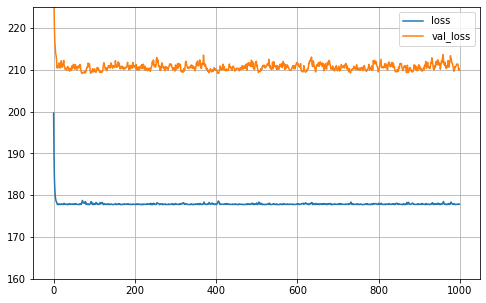

In [80]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.gca().set_ylim(160, 225)
plt.grid(True)
plt.show()

# Compute Generalization Error

### GradientBoostingRegressor Model MSE

In [81]:
y_pred_gbrt = gbrt.predict(X_test)
gbrt_mse = mean_squared_error(y_test, y_pred_gbrt)
print("GradientBoostingRegressor Model MSE:", round(gbrt_mse,3))

GradientBoostingRegressor Model MSE: 121.497


### GradientBoostingRegressor Scaled Model MSE

In [82]:
y_pred_gbrt_scaled = gbrt_scaled.predict(X_test_scaled)
gbrt_scaled_mse = mean_squared_error(y_test, y_pred_gbrt_scaled)
print("GradientBoostingRegressor Scaled Model MSE:", round(gbrt_scaled_mse,3))

GradientBoostingRegressor Scaled Model MSE: 121.703


### GradientBoostingRegressor PCA Model MSE

In [83]:
y_pred_gbrt_PCA = gbrt.predict(X_test)
gbrt_PCA_mse = mean_squared_error(y_test, y_pred_gbrt_PCA)
print("GradientBoostingRegressor PCA Model MSE:", round(gbrt_PCA_mse,3))

GradientBoostingRegressor PCA Model MSE: 121.497


### GradientBoostingRegressor PCA Scaled Model MSE

In [84]:
y_pred_gbrt_PCA_scaled = gbrt_scaled.predict(X_test_scaled)
gbrt_PCA_scaled_mse = mean_squared_error(y_test, y_pred_gbrt_PCA_scaled)
print("GradientBoostingRegressor PCA Scaled Model MSE:", round(gbrt_PCA_scaled_mse,3))

GradientBoostingRegressor PCA Scaled Model MSE: 121.703


### RandomForestRegressor Model MSE

In [85]:
y_pred_rnd = rnd_reg.predict(X_test)
rnd_mse = mean_squared_error(y_test, y_pred_rnd)
print("RandomForestRegressor Model MSE:", round(rnd_mse,3))

RandomForestRegressor Model MSE: 122.449


### RandomForestRegressor Scaled Model MSE

In [86]:
y_pred_rnd_scaled = rnd_reg_scaled.predict(X_test_scaled)
rnd_scaled_mse = mean_squared_error(y_test, y_pred_rnd_scaled)
print("RandomForestRegressor Scaled Model MSE:", round(rnd_scaled_mse,3))

RandomForestRegressor Scaled Model MSE: 122.489


### RandomForestRegressor PCA Model MSE

In [87]:
y_pred_rnd_PCA = rnd_reg.predict(X_test)
rnd_PCA_mse = mean_squared_error(y_test, y_pred_rnd_PCA)
print("RandomForestRegressor PCA Model MSE:", round(rnd_PCA_mse,3))

RandomForestRegressor PCA Model MSE: 122.449


### RandomForestRegressor PCA Scaled Model MSE

In [88]:
y_pred_rnd_PCA_scaled = rnd_reg_scaled.predict(X_test_scaled)
rnd_scaled_PCA_mse = mean_squared_error(y_test, y_pred_rnd_PCA_scaled)
print("RandomForestRegressor PCA Scaled Model MSE:", round(rnd_scaled_PCA_mse,3))

RandomForestRegressor PCA Scaled Model MSE: 122.489


### DecisionTreeRegressor Model MSE

In [89]:
y_pred_tree = tree_reg.predict(X_test)
tree_mse = mean_squared_error(y_test, y_pred_tree)
print("DecisionTreeRegressor Model MSE:", round(tree_mse,3))

DecisionTreeRegressor Model MSE: 124.925


### DecisionTreeRegressor Scaled Model MSE

In [90]:
y_pred_tree_scaled = tree_reg_scaled.predict(X_test_scaled)
tree_scaled_mse = mean_squared_error(y_test, y_pred_tree_scaled)
print("DecisionTreeRegressor Scaled Model MSE:", round(tree_scaled_mse,3))

DecisionTreeRegressor Scaled Model MSE: 124.925


### DecisionTreeRegressor PCA Model MSE

In [91]:
y_pred_tree_PCA = tree_reg.predict(X_test)
tree_PCA_mse = mean_squared_error(y_test, y_pred_tree_PCA)
print("DecisionTreeRegressor Model MSE:", round(tree_PCA_mse,3))

DecisionTreeRegressor Model MSE: 124.925


### DecisionTreeRegressor PCA Scaled Model MSE

In [92]:
y_pred_tree_PCA_scaled = tree_reg_scaled.predict(X_test_scaled)
tree_scaled_PCA_mse = mean_squared_error(y_test, y_pred_tree_PCA_scaled)
print("DecisionTreeRegressor Scaled Model MSE:", round(tree_scaled_PCA_mse,3))

DecisionTreeRegressor Scaled Model MSE: 124.925


### KNeighborsRegressor

In [93]:
y_pred_knn = knn_reg.predict(X_test)
knn_mse = mean_squared_error(y_test, y_pred_knn)
print("KNeighborsRegressor Model MSE:", round(knn_mse,3))

KNeighborsRegressor Model MSE: 123.247


### KNeighborsRegressor w/Scaling

In [94]:
y_pred_knn_scaled = knn_scaled_reg.predict(X_test_scaled)
knn_scaled_mse = mean_squared_error(y_test, y_pred_knn_scaled)
print("KNeighborsRegressor Scaled Model MSE:", round(knn_scaled_mse,3))

KNeighborsRegressor Scaled Model MSE: 196.962


### VotingRegressor

In [95]:
y_pred_voting_reg = voting_reg.predict(X_test_scaled)
voting_reg_mse = mean_squared_error(y_test, y_pred_voting_reg)
print("VotingRegressor Model MSE:", round(voting_reg_mse,3))

VotingRegressor Model MSE: 170.702


### Artificial Neural Networks MSE

In [96]:
ANN_mse = model_ANN.evaluate(X_test,y_test)
print(ANN_mse)

5/5 [==============================] - 0s 1ms/step - loss: 166.5900
166.5900115966797


# Compare Generalization across models

In [97]:
print("GradientBoostingRegressor Model MSE:", round(gbrt_mse,3))
print("GradientBoostingRegressor Scaled Model MSE:", round(gbrt_scaled_mse,3))
print("GradientBoostingRegressor PCA Model MSE:", round(gbrt_PCA_mse,3))
print("GradientBoostingRegressor PCA Scaled Model MSE:", round(gbrt_PCA_scaled_mse,3))
print("RandomForestRegressor Model MSE:", round(rnd_mse,3))
print("RandomForestRegressor Scaled Model MSE:", round(rnd_scaled_mse,3))
print("RandomForestRegressor PCA Model MSE:", round(rnd_PCA_mse,3))
print("RandomForestRegressor PCA Scaled Model MSE:", round(rnd_scaled_PCA_mse,3))
print("DecisionTreeRegressor Model MSE:", round(tree_mse,3))
print("DecisionTreeRegressor Scaled Model MSE:", round(tree_scaled_mse,3))
print("DecisionTreeRegressor Model MSE:", round(tree_PCA_mse,3))
print("DecisionTreeRegressor Scaled Model MSE:", round(tree_scaled_PCA_mse,3))
print("KNeighborsRegressor Model MSE:", round(knn_mse,3))
print("KNeighborsRegressor Scaled Model MSE:", round(knn_scaled_mse,3))
print("VotingRegressor Model MSE:", round(voting_reg_mse,3))
print("Artificial Neural Network Scaled Model MSE:",round(ANN_mse,3))
print("Better Seed Benchmark Model MSE:", round(mse_BetterSeed_Scaled,3))
print("Better Record Benchmark Model MSE:", round(mse_BetterRecord_Scaled,3))

GradientBoostingRegressor Model MSE: 121.497
GradientBoostingRegressor Scaled Model MSE: 121.703
GradientBoostingRegressor PCA Model MSE: 121.497
GradientBoostingRegressor PCA Scaled Model MSE: 121.703
RandomForestRegressor Model MSE: 122.449
RandomForestRegressor Scaled Model MSE: 122.489
RandomForestRegressor PCA Model MSE: 122.449
RandomForestRegressor PCA Scaled Model MSE: 122.489
DecisionTreeRegressor Model MSE: 124.925
DecisionTreeRegressor Scaled Model MSE: 124.925
DecisionTreeRegressor Model MSE: 124.925
DecisionTreeRegressor Scaled Model MSE: 124.925
KNeighborsRegressor Model MSE: 123.247
KNeighborsRegressor Scaled Model MSE: 196.962
VotingRegressor Model MSE: 170.702
Artificial Neural Network Scaled Model MSE: 166.59
Better Seed Benchmark Model MSE: 139.056
Better Record Benchmark Model MSE: 142.423


| Item | Models            | No Scaling | Scaling | No Scaling PCA | Scaling PCA |
| ---- | ----------------- | ---------- | --------| -------------- | ----------- |
| MSE  | Gradient Boosting |__121.497__ | 121.703 | 121.497        | 121.703     |
|      | Random Forest     | 122.449    | 122.489 | 122.449        | 122.489     |
|      | Decision Tree     | 124.925    | 124.925 | 124.925        | 124.925     |
|      | KNeighbors        | 123.247    | 196.962 |                |             |
|      | ANN               | 166.590    |         |                |             |
|      | VotingReg         | 170.702    |         |                |             |
|      | BM Better Seed    | 139.056    |         |                |             |
|      | BM Better Record  | 142.423    |         |                |             |

# Model Decision

The `Gradient Boosting Model` with no scaling was the lowest MSE and is the model I have chosen. The PCA for that non-scaled model didn't seem to make a signifcant change in the feature set.

The other individual models, according to the MSE, performed very similarly using their respective optimal parameters when fitting. The Voting Regression Model didn't perform as well as I initially thought it would. Upon further reflection that makes sense to me because the individual model optimal parameters and predictions may not actually combine well with the other models to produce a more optimal prediction, with many times the differing models potentially pulling and skewing the results in multiple directions for each prediction.

I was able to show that the individual models I ran, based only on MSE, would be beneficial to use over the benchmark strategies when filling out a tournament bracket to only select the team with the better seed or record.

The features and distribution of those features didn't need to be scaled or narrowed using PCA, and so there wasn't any clear benefit reflected in the MSE using those processes. As a result, the later models I created and fitted I decided that those processes didn't need to be included as they didn't add any clear benefit.



# Creating Flask Application
Wasn't too familiar with Flask so used the source provided to me when discussing my project proposal.
https://medium.com/analytics-vidhya/deploying-a-machine-learning-model-using-flask-for-beginners-674944714b86

In [98]:
#serializing model to a file called model.pkl
#using gbrt as the chosen model
pickle.dump(gbrt,open("model.pkl","wb"))

In [99]:
#creating instance of the class
app = Flask(__name__,template_folder='templates')

#to tell flask what url should trigger the function index()
@app.route('/')
@app.route('/index')
def index():
    return flask.render_template('index.html')


Index and Result html files needed will be stored in templates folder that will also be stored in the Google Drive.

## Finding feature list that will be the inputs on the application

In [100]:
X_train.columns

Index(['assist_percentage', 'block_percentage', 'offensive_rating',
       'offensive_rebound_percentage', 'opp_assist_percentage',
       'opp_block_percentage', 'opp_free_throw_attempt_rate',
       'opp_free_throw_percentage', 'opp_free_throws_per_field_goal_attempt',
       'opp_offensive_rebound_percentage', 'opp_steal_percentage',
       'opp_three_point_field_goal_percentage',
       'opp_two_point_field_goal_percentage', 'opp_total_rebound_percentage',
       'opp_true_shooting_percentage', 'pace', 'simple_rating_system',
       'steal_percentage', 'strength_of_schedule', 'three_point_attempt_rate',
       'three_point_field_goal_percentage', 'two_point_field_goal_percentage',
       'true_shooting_percentage', 'turnover_percentage', 'win_percentage',
       'seed_difference'],
      dtype='object')

In [101]:
#prediction function
def InputPredictor(to_predict_inputs):
    to_predict = np.array(to_predict_inputs).reshape(1,26)
    loaded_model = pickle.load(open("model.pkl","rb"))
    result = loaded_model.predict(to_predict)
    return result[0]

@app.route('/result',methods = ['POST'])
def result():
    if request.method == 'POST':
        to_predict_inputs = request.form.values()
        to_predict_inputs = list(map(float,to_predict_inputs))
        result = InputPredictor(to_predict_inputs)
        
        if float(result) > 0:
            prediction = 'Home Team will win by ' + str(math.ceil(result)) + ' point(s)'
        elif float(result) < 0:
            prediction = 'Away Team will win by ' + str(abs(math.floor(result))) + ' point(s)'
        elif float(result) == 0:
            prediction = 'There will be a tie'
            
        return render_template("result.html",prediction = prediction)

In [102]:
if __name__ == '__main__':
    app.run(debug=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [23/Apr/2022 22:03:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2022 22:03:53] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/Apr/2022 22:05:26] "POST /result HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2022 22:05:33] "POST /result HTTP/1.1" 200 -
127.0.0.1 - - [23/Apr/2022 22:41:03] "POST /result HTTP/1.1" 200 -


# Creating predictions using real games through the Flask Application

In [81]:
#Combining test set data to make predictions off of and compare to actual results
Flask_predictions = pd.concat([game_info_test, X_test,y_test], axis=1)
Flask_predictions = Flask_predictions.rename(columns={0:"Final_Score_Difference"})
Flask_predictions

,Year,Home_Team,Away_Team,assist_percentage,block_percentage,offensive_rating,offensive_rebound_percentage,opp_assist_percentage,opp_block_percentage,opp_free_throw_attempt_rate,...,steal_percentage,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,true_shooting_percentage,turnover_percentage,win_percentage,seed_difference,Final_Score_Difference
497,2017,Villanova,Mount St. Mary's,0.063,-0.006,18.5,0.070,0.131,-0.013,-0.105,...,0.020,12.79,0.064,0.011,0.098,0.076,-0.021,0.333,-15,20
244,2013,Syracuse,California,-0.004,0.079,6.6,0.063,0.165,0.008,0.029,...,0.050,0.86,0.068,0.033,-0.003,0.008,-0.007,0.114,-8,6
552,2018,Texas A&M,Michigan,0.015,0.072,-4.9,0.085,0.139,-0.002,-0.022,...,-0.019,1.21,-0.103,-0.028,-0.027,-0.026,0.039,-0.176,4,-27
213,2013,Louisville,Colorado State,0.052,0.057,-2.3,-0.030,0.059,0.001,-0.015,...,0.088,3.30,0.029,-0.005,0.017,0.005,0.012,0.132,-7,26
549,2018,TCU,Syracuse,0.153,-0.080,12.7,-0.005,-0.166,0.023,-0.009,...,-0.016,-0.34,0.024,0.077,0.085,0.072,-0.008,0.014,-5,-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,2014,Michigan State,Delaware,0.219,0.049,1.6,0.031,0.054,-0.016,0.023,...,0.018,10.48,0.018,0.045,0.026,0.027,0.031,0.049,-9,15
369,2015,West Virginia,Buffalo,0.050,-0.026,-3.6,0.057,0.040,0.022,0.212,...,0.046,7.69,0.033,-0.025,-0.021,-0.034,0.010,0.017,-7,6
79,2011,Florida,UCLA,-0.056,-0.041,6.5,0.012,-0.015,0.006,-0.052,...,0.010,-0.36,0.027,0.025,0.010,0.008,-0.029,0.108,-5,8
23,2010,Marquette,Washington,0.086,-0.047,3.4,-0.057,0.101,0.037,-0.152,...,0.021,0.74,0.094,0.077,-0.016,0.024,-0.010,-0.075,-5,-2


## First Game Prediction

In [82]:
#Getting first game shown in the test set
Flask_predictions.iloc[0]

Year                                                  2017
Home_Team                                        Villanova
Away_Team                                 Mount St. Mary's
assist_percentage                                    0.063
block_percentage                                    -0.006
offensive_rating                                      18.5
offensive_rebound_percentage                          0.07
opp_assist_percentage                                0.131
opp_block_percentage                                -0.013
opp_free_throw_attempt_rate                         -0.105
opp_free_throw_percentage                            0.043
opp_free_throws_per_field_goal_attempt               -0.06
opp_offensive_rebound_percentage                    -0.072
opp_steal_percentage                                -0.015
opp_three_point_field_goal_percentage                -0.03
opp_two_point_field_goal_percentage                 -0.004
opp_total_rebound_percentage                        -0.0

Inputting above data into prediction tool:
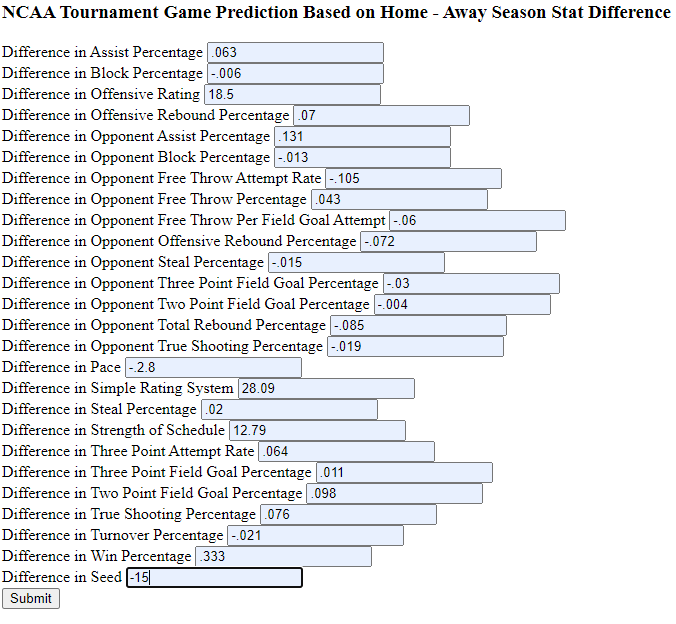

Prediction through Flask:
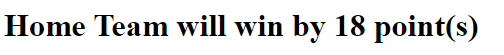
In line with the 20 point actual win by Villanova(Home Team)

### Confirming Flask model is working as intended

In [92]:
X_test.iloc[0]

assist_percentage                          0.063
block_percentage                          -0.006
offensive_rating                          18.500
offensive_rebound_percentage               0.070
opp_assist_percentage                      0.131
opp_block_percentage                      -0.013
opp_free_throw_attempt_rate               -0.105
opp_free_throw_percentage                  0.043
opp_free_throws_per_field_goal_attempt    -0.060
opp_offensive_rebound_percentage          -0.072
opp_steal_percentage                      -0.015
opp_three_point_field_goal_percentage     -0.030
opp_two_point_field_goal_percentage       -0.004
opp_total_rebound_percentage              -0.085
opp_true_shooting_percentage              -0.019
pace                                      -2.800
simple_rating_system                      28.090
steal_percentage                           0.020
strength_of_schedule                      12.790
three_point_attempt_rate                   0.064
three_point_field_go

In [93]:
# This result is rounding up to the win by 18 shown above through the application.
y_pred_gbrt[0]

17.553166233183706

## Second Game Prediction

In [83]:
Flask_predictions.iloc[1]

Year                                            2013
Home_Team                                   Syracuse
Away_Team                                 California
assist_percentage                             -0.004
block_percentage                               0.079
offensive_rating                                 6.6
offensive_rebound_percentage                   0.063
opp_assist_percentage                          0.165
opp_block_percentage                           0.008
opp_free_throw_attempt_rate                    0.029
opp_free_throw_percentage                     -0.015
opp_free_throws_per_field_goal_attempt         0.015
opp_offensive_rebound_percentage               0.052
opp_steal_percentage                           0.017
opp_three_point_field_goal_percentage         -0.053
opp_two_point_field_goal_percentage             0.01
opp_total_rebound_percentage                   0.003
opp_true_shooting_percentage                  -0.013
pace                                          

Inputting above data into prediction tool:
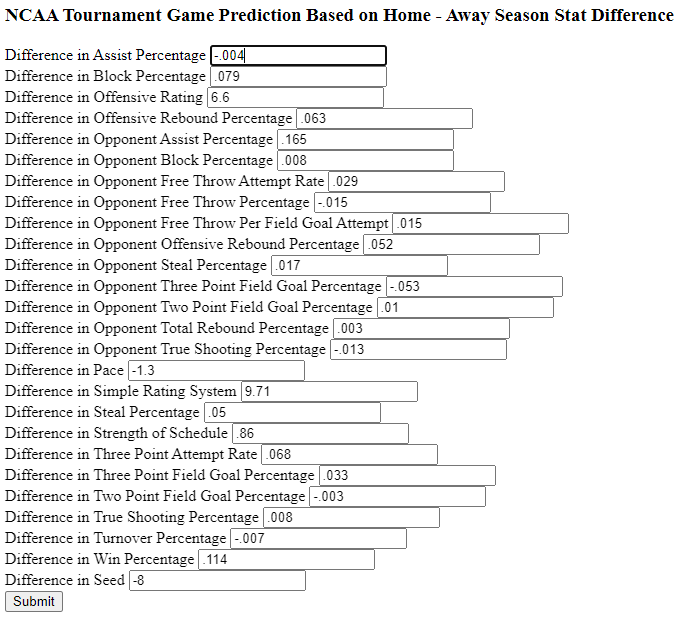

Prediction through Flask:
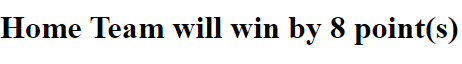
In line with the 6 point actual win by Syracuse(Home Team)

### Confirming Flask model is working as intended

In [94]:
X_test.iloc[1]

assist_percentage                        -0.004
block_percentage                          0.079
offensive_rating                          6.600
offensive_rebound_percentage              0.063
opp_assist_percentage                     0.165
opp_block_percentage                      0.008
opp_free_throw_attempt_rate               0.029
opp_free_throw_percentage                -0.015
opp_free_throws_per_field_goal_attempt    0.015
opp_offensive_rebound_percentage          0.052
opp_steal_percentage                      0.017
opp_three_point_field_goal_percentage    -0.053
opp_two_point_field_goal_percentage       0.010
opp_total_rebound_percentage              0.003
opp_true_shooting_percentage             -0.013
pace                                     -1.300
simple_rating_system                      9.710
steal_percentage                          0.050
strength_of_schedule                      0.860
three_point_attempt_rate                  0.068
three_point_field_goal_percentage       

In [95]:
y_pred_gbrt[1]

7.608803021730753